# Analyze v3 generated network

In [1]:
import itertools
import math
import os
import random
import re
import sys
import tempfile
import time
import warnings

import numpy as np
import networkx as nx
import pyarrow as pa
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib.ticker import ScalarFormatter
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
import scipy.interpolate
import scipy.stats
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import statsmodels.stats.multitest

sys.path.append('../..')
import aggregate_networks
import chip_validation2

pd.set_option('display.precision', 2)
%matplotlib inline

---

## Read in all the relevant data

In [90]:
annotation_df = pd.read_csv('../../../Papers/Mycobacterium_tuberculosis_H37Rv_txt_v5.txt',
    sep='\t', index_col=None, usecols=['Locus', 'Name', 'Function', 'Product', 'UniProt_AC'])
annotation_df = annotation_df[~annotation_df['Locus'].str.startswith('MTB')]
annotation_df2 = annotation_df.drop_duplicates(subset='Locus').set_index('Locus')
annotation_df.head()

Locus     Name                                           Function  \
56  Rv2007c     fdxA                     Involved in electron transfer.   
57   Rv3451     cut3  Hydrolysis of cutin (a polyester that forms th...   
58   Rv3452     cut4  Hydrolysis of cutin (a polyester that forms th...   
59  Rv2658c  Rv2658c                                            Unknown   
60  Rv2612c    pgsA1  Catalyzes the transfer of a free alcohol (inos...   

                                              Product UniProt_AC  
56                                    Ferredoxin FdxA     P9WNE7  
57                   Probable cutinase precursor Cut3     P9WP39  
58                   Probable cutinase precursor Cut4     O06319  
59                          Possible prophage protein     P9WL47  
60  PI synthase PgsA1 (phosphatidylinositol syntha...     P9WPG7

In [91]:
annotation_df['Locus'].eq(annotation_df['Name']).sum() / len(annotation_df)

0.5144694533762058

In [103]:
annotation_df['Product'].str.contains('ypothetical').sum() / len(annotation_df)

0.17734355676477864

In [106]:
annotation_df.loc[annotation_df['Product'].str.contains('ypothetical'), 'Product'].unique()

array(['Hypothetical protein', 'Conserved hypothetical protein',
       'Hypothetical alanine arginine proline rich protein',
       'Hypothetical short protein',
       'Probable hypothetical membrane protein',
       'Conserved hypothetical integral membrane protein YrbE2B',
       'Conserved hypothetical ala-, pro-rich protein',
       'Conserved hypothetical membrane protein',
       'Conserved hypothetical integral membrane protein YrbE3B',
       'Hypothetical proline and serine rich protein',
       'Conserved hypothetical alanine leucine valine rich protein',
       'Conserved hypothetical alanine and leucine rich protein',
       'Conserved hypothetical alanine, arginine-rich protein',
       'Conserved hypothetical alanine and arginine rich protein',
       'Conserved hypothetical protein SseC1',
       'Hypothetical oxidoreductase',
       'Conserved hypothetical cysteine rich protein (fragment)',
       'Hypothetical methlytransferase (methylase)',
       'Conserved hypothe

In [101]:
annotation_df['Function'].isin(('Unknown', 'Function unknown')).sum() / len(annotation_df)

0.4620331437051694

In [3]:
regulators_df = pd.read_csv('../../mount2/mtb_tfs_20240213.txt', header=None)

regulatory_space = pd.Index(
    data=((regulator, gene) for regulator in regulators_df[0] for gene in annotation_df['Locus'].unique()),
    name=('Regulator', 'Gene')
)
regulatory_space

MultiIndex([('Rv0019c', 'Rv2007c'),
            ('Rv0019c',  'Rv3451'),
            ('Rv0019c',  'Rv3452'),
            ('Rv0019c', 'Rv2658c'),
            ('Rv0019c', 'Rv2612c'),
            ('Rv0019c', 'Rv1724c'),
            ('Rv0019c',  'Rv1772'),
            ('Rv0019c', 'Rv1778c'),
            ('Rv0019c', 'Rv1914c'),
            ('Rv0019c',  'Rv1957'),
            ...
            ( 'Rv3911',  'Rv3913'),
            ( 'Rv3911', 'Rv3918c'),
            ( 'Rv3911', 'Rv3916c'),
            ( 'Rv3911', 'Rv3919c'),
            ( 'Rv3911', 'Rv3920c'),
            ( 'Rv3911',  'Rv3216'),
            ( 'Rv3911', 'Rv3924c'),
            ( 'Rv3911', 'Rv0277A'),
            ( 'Rv3911', 'Rv2427A'),
            ( 'Rv3911', 'Rv3922c')],
           names=['Regulator', 'Gene'], length=862634)

In [4]:
# set up data

tfoe_mapping = {
	'Rv0061': 'Rv0061c',
	'Rv2427Ac': 'Rv2427A',
}

tfoe_extra = [ # maybe generate this list by TFOE_genes - annotation_genes?
	'Rv1784', 'Rvns01', 'Rvns02', 'Rvnt01', 'Rvnt02', 'Rvnt03', 'Rvnt05', 'Rvnt06', 'Rvnt07', 'Rvnt08', 'Rvnt11', 'Rvnt12',
    'Rvnt13', 'Rvnt15', 'Rvnt17', 'Rvnt19', 'Rvnt21', 'Rvnt22', 'Rvnt24', 'Rvnt27', 'Rvnt28', 'Rvnt29', 'Rvnt30', 'Rvnt32',
    'Rvnt33', 'Rvnt34', 'Rvnt40', 'Rvnt41'
]

constituent_networks_df = pd.DataFrame((
    ('ARACNe', 'RNA', '../aracne_mtb-rna-20240625-50b-pneg6_nonoperon.txt',),
    ('ARACNe', 'TFOE', '../aracne_tfoefullpysnail-50b-pneg6_nonoperon.txt',),
    ('CLR', 'RNA', '../clr_mtb-rna-20240625_nonoperon.txt',),
    ('CLR', 'TFOE', '../clr_tfoefullpysnail_nonoperon.txt',),
    ('cMonkey2', 'RNA', '../cmonkey2_mtb-rna-20240625_nonoperon.txt',),
    ('cMonkey2', 'TFOE', '../cmonkey2_tfoe-full-pysnail_nonoperon.txt',),
    ('Elasticnet', 'RNA', '../elasticnet_v0.2_mtb-rna-20240625_nonoperon.txt',),
    ('Elasticnet', 'TFOE', '../elasticnet_v0.2_tfoe-full-pysnail_nonoperon.txt',),
    ('GENIE3', 'RNA', '../genie3_mtb-rna-20240625_nonoperon.txt',),
    ('GENIE3', 'TFOE', '../genie3_tfoe-full-pysnail_nonoperon.txt',),
    ('iModulon', 'RNA', '../imodulon_mtb-rna-20240625_nonoperon_dedup.txt',),
    ('iModulon', 'TFOE', '../imodulon_tfoe-full-pysnail_nonoperon_dedup.txt',),
), columns=['Method', 'Dataset', 'File'])

# read in each file

constituent_networks_df['network_df'] = constituent_networks_df['File'].map(
    lambda file: pd.read_csv(file, sep='\t', header=None, index_col=None, names=['Regulator', 'Gene', 'Score'])
)

# assign Rank column to each constituent network df

constituent_networks_df['network_df'].map( # don't set it back to the column: insert returns void; just use `map` as essentially a looping construct
    lambda df: df.insert(2, 'Rank', df.index.to_series() + 1)
)

# fix misannotations and drop out of scope genes in each constituent TFOE network df

for network_df in constituent_networks_df.loc[constituent_networks_df['Dataset'].eq('TFOE'), 'network_df']:
    network_df_invalid = network_df[network_df['Gene'].isin(tfoe_extra) | network_df['Regulator'].isin(tfoe_extra)]
    network_df.drop(index=network_df_invalid.index, inplace=True)
    network_df['Gene'] = network_df['Gene'].map(lambda gene: tfoe_mapping[gene] if gene in tfoe_mapping else gene)
    network_df['Regulator'] = network_df['Regulator'].map(lambda gene: tfoe_mapping[gene] if gene in tfoe_mapping else gene)
    network_df.reset_index(inplace=True)

constituent_networks_df

Method Dataset                                               File  \
0       ARACNe     RNA  ../aracne_mtb-rna-20240625-50b-pneg6_nonoperon...   
1       ARACNe    TFOE  ../aracne_tfoefullpysnail-50b-pneg6_nonoperon.txt   
2          CLR     RNA              ../clr_mtb-rna-20240625_nonoperon.txt   
3          CLR    TFOE               ../clr_tfoefullpysnail_nonoperon.txt   
4     cMonkey2     RNA         ../cmonkey2_mtb-rna-20240625_nonoperon.txt   
5     cMonkey2    TFOE        ../cmonkey2_tfoe-full-pysnail_nonoperon.txt   
6   Elasticnet     RNA  ../elasticnet_v0.2_mtb-rna-20240625_nonoperon.txt   
7   Elasticnet    TFOE  ../elasticnet_v0.2_tfoe-full-pysnail_nonoperon...   
8       GENIE3     RNA           ../genie3_mtb-rna-20240625_nonoperon.txt   
9       GENIE3    TFOE          ../genie3_tfoe-full-pysnail_nonoperon.txt   
10    iModulon     RNA   ../imodulon_mtb-rna-20240625_nonoperon_dedup.txt   
11    iModulon    TFOE  ../imodulon_tfoe-full-pysnail_nonoperon_dedup.txt   

                                           network_df  
0         Regulator     Gene   Rank  Score
0      ...  
1          index Regulator     Gene   Rank  Score
...  
2          Regulator     Gene    Rank     Score
0 ...  
3            index Regulator     Gene    Rank     ...  
4          Regulator     Gene    Rank  Score
0    ...  
5            index Regulator     Gene    Rank  Sco...  
6          Regulator     Gene    Rank     Score
0 ...  
7            index Regulator     Gene    Rank     ...  
8         Regulator     Gene   Rank     Score
0   ...  
9          index Regulator     Gene   Rank     Sco...  
10        Regulator     Gene   Rank     Score
0   ...  
11        index Regulator     Gene  Rank     Score...

In [5]:
distenriched3_df = pd.read_csv(
    'aggregate-mtb_candidate_v3_undirected.txt', sep='\t', index_col=False, names=['Regulator', 'Gene', 'Rank'])
distenriched3_df['Edge'] = distenriched3_df['Regulator'].str.cat(distenriched3_df['Gene'], sep='_')
print(distenriched3_df.shape)
distenriched3_df.head()

(68226, 4)


Regulator     Gene  Rank             Edge
0    Rv1657   Rv1659     1    Rv1657_Rv1659
1    Rv1657   Rv1658     2    Rv1657_Rv1658
2   Rv3249c  Rv3250c     3  Rv3249c_Rv3250c
3    Rv0081   Rv0085     4    Rv0081_Rv0085
4   Rv3417c   Rv0440     5   Rv3417c_Rv0440

### Sanz

In [6]:
sanz_sources_df = pd.read_csv('../../../Papers/Sanz2011_SupplementalMaterialS1.txt',
    sep='\t', header=None, index_col=0, names=['Source'],
    skiprows=7, nrows=65)

sanz_sources_df.rename(index={ # best guess at mismatch between reference list and usage
    '63a': '63',
    '63b': '64',
}, inplace=True)

sanz_methods_df = pd.read_csv('../../../Papers/Sanz2011_SupplementalMaterialS1.txt',
    sep='\t', header=None, index_col=0, names=['Methodology'],
    skiprows=75, nrows=22)

sanz_network_df = pd.read_csv('../../../Papers/Sanz2011_SupplementalMaterialS1.txt',
    sep=r'\s+', header=None, index_col=None, names=['Reg_idx', 'Target_idx', 'Regulator', 'Target', 'Sources_code', 'Methods_code'],
    skiprows=98)

sanz_network_df[['Sources_count', 'Sources_csv']] = sanz_network_df['Sources_code'].str.split(':', expand=True)
sanz_network_df[['Methods_count', 'Methods_csv']] = sanz_network_df['Methods_code'].str.split(':', expand=True)

sanz_network_df['Source'] = sanz_network_df['Sources_csv'].map(
    lambda source: np.nan if ',' in source else sanz_sources_df.at[source, 'Source'])
sanz_network_df['Method'] = sanz_network_df['Methods_csv'].map(
    lambda method: np.nan if ',' in method else sanz_methods_df.at[int(method), 'Methodology'])  # why int() here but not for source? I don't know; it works.

# display(sanz_sources_df)
# display(sanz_methods_df)
print(sanz_network_df.shape)
sanz_network_df.head()

(3212, 12)


Reg_idx  Target_idx Regulator   Target Sources_code Methods_code  \
0        1           1    Rv0001   Rv0001       2:0,62         1:13   
1        1           2    Rv0001   Rv0002       2:0,62         1:13   
2        1           3    Rv0001   Rv0003       2:0,62         1:13   
3        1           4    Rv0001  Rv3396c       2:0,62         1:13   
4        1           5    Rv0001  Rv3411c       2:0,62         1:13   

  Sources_count Sources_csv Methods_count Methods_csv Source  \
0             2        0,62             1          13    NaN   
1             2        0,62             1          13    NaN   
2             2        0,62             1          13    NaN   
3             2        0,62             1          13    NaN   
4             2        0,62             1          13    NaN   

                             Method  
0  E.coli orthology based inference  
1  E.coli orthology based inference  
2  E.coli orthology based inference  
3  E.coli orthology based inference  
4  E.coli orthology based inference

Interesting.... There's a chance we want to exclude some of these methodologies, if we're going for a concrete set of edges likely to be surfaced with a method like ours (in theory).

Shuyi likes methods 4-9

In [7]:
print('Whole Sanz network:', len(sanz_network_df))

print('Only including at least one method considered rock solid:')
solid_methods = ['4', '5', '6', '7', '8', '9']#, '12', '18', '19', '21']
sanz_network_df['Methods_csv'].map(lambda csv: any(method in csv.split(',') for method in solid_methods)).sum()

Whole Sanz network: 3212
Only including at least one method considered rock solid:


449

In [8]:
sanz_solid_df = sanz_network_df[sanz_network_df['Methods_csv'].map(lambda csv: any(method in csv.split(',') for method in solid_methods))].copy()
sanz_solid_df['Edge'] = sanz_solid_df['Regulator'].str.cat(sanz_solid_df['Target'], sep='_')
sanz_solid_df

Reg_idx  Target_idx Regulator   Target  Sources_code   Methods_code  \
6           6           7    Rv0117  Rv1908c      3:0,8,62         2:13,8   
16         17          20    Rv0353   Rv0350  4:0,36,37,63  5:1,2,11,16,7   
25         28          30    Rv0491   Rv0490  4:0,38,62,63    4:1,13,7,11   
50         55          55    Rv0967   Rv0967        2:0,24        3:1,3,7   
53         58          58    Rv0981   Rv0981      3:0,9,26   5:1,2,3,7,11   
...       ...         ...       ...      ...           ...            ...   
2116      198        1084   Rv1846c   Rv1309          1:31       3:3,9,11   
2117      198         981   Rv1846c   Rv1310          1:31       3:3,9,11   
2118      198        1299   Rv1846c   Rv1311          1:31       3:3,9,11   
2119      198         982   Rv1846c   Rv1312          1:31       3:3,9,11   
2120      198         827   Rv1846c  Rv3921c          1:31       3:3,9,11   

     Sources_count Sources_csv Methods_count  Methods_csv  \
6                3      0,8,62             2         13,8   
16               4  0,36,37,63             5  1,2,11,16,7   
25               4  0,38,62,63             4    1,13,7,11   
50               2        0,24             3        1,3,7   
53               3      0,9,26             5   1,2,3,7,11   
...            ...         ...           ...          ...   
2116             1          31             3       3,9,11   
2117             1          31             3       3,9,11   
2118             1          31             3       3,9,11   
2119             1          31             3       3,9,11   
2120             1          31             3       3,9,11   

                                                Source Method             Edge  
6                                                  NaN    NaN   Rv0117_Rv1908c  
16                                                 NaN    NaN    Rv0353_Rv0350  
25                                                 NaN    NaN    Rv0491_Rv0490  
50                                                 NaN    NaN    Rv0967_Rv0967  
53                                                 NaN    NaN    Rv0981_Rv0981  
...                                                ...    ...              ...  
2116  Sala, C. et al. (2009): Mol Microbiol. 71: blaI.    NaN   Rv1846c_Rv1309  
2117  Sala, C. et al. (2009): Mol Microbiol. 71: blaI.    NaN   Rv1846c_Rv1310  
2118  Sala, C. et al. (2009): Mol Microbiol. 71: blaI.    NaN   Rv1846c_Rv1311  
2119  Sala, C. et al. (2009): Mol Microbiol. 71: blaI.    NaN   Rv1846c_Rv1312  
2120  Sala, C. et al. (2009): Mol Microbiol. 71: blaI.    NaN  Rv1846c_Rv3921c  

[449 rows x 13 columns]

In [9]:
sanz_solid_df['RegName'] = sanz_solid_df['Regulator'].map(annotation_df2['Name'])
sanz_solid_df['TarName'] = sanz_solid_df['Target'].map(annotation_df2['Name'])
sanz_solid_df[['RegName', 'TarName']].head()

RegName TarName
6     oxyS    katG
16    hspR    dnaK
25   regX3   senX3
50    csoR    csoR
53    mprA    mprA

## Degree distributions

In [36]:
distenriched3_node_df = pd.DataFrame(index=annotation_df['Locus'])

distenriched3_node_df['Regulator'] = distenriched3_node_df.index.isin(regulators_df[0])

distenriched3_g = nx.from_pandas_edgelist(distenriched3_df, source='Regulator', target='Gene', create_using=nx.DiGraph)

for node, out_degree in distenriched3_g.out_degree:
    distenriched3_node_df.at[node, 'OutDegree'] = out_degree

distenriched3_node_df

Regulator  OutDegree
Locus                        
Rv2007c      False        0.0
Rv3451       False        0.0
Rv3452       False        0.0
Rv2658c      False        0.0
Rv2612c      False        0.0
...            ...        ...
Rv3216       False        0.0
Rv3924c      False        0.0
Rv0277A      False        NaN
Rv2427A      False        0.0
Rv3922c      False        0.0

[4043 rows x 2 columns]

In [37]:
distenriched3_node_df.loc['Rv1990c', :]

Regulator     True
OutDegree    351.0
Name: Rv1990c, dtype: object

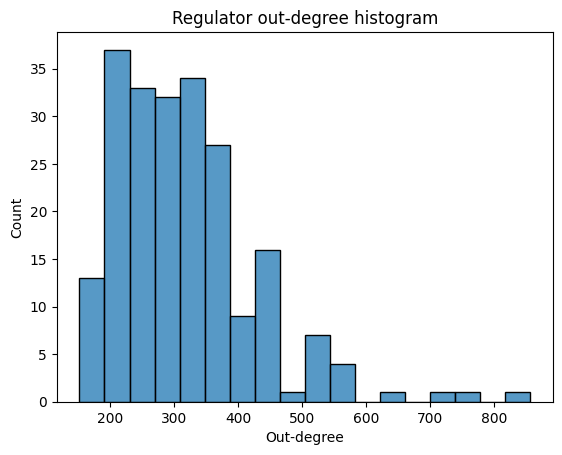

In [382]:
ax = sns.histplot(distenriched3_node_df.loc[distenriched3_node_df['Regulator'], 'OutDegree'])
ax.set_xlabel('Out-degree')
plt.title('Regulator out-degree histogram');
# power law: y = a * x^k (a and k being constants -- I think we'd fit them; cf https://doi.org/10.1039/B908681A; note concerns in that paper)

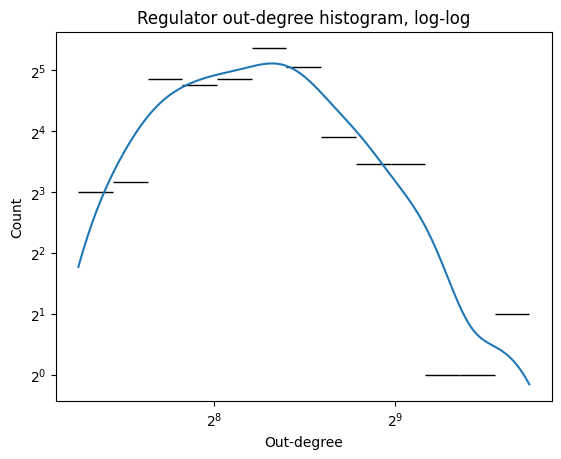

In [383]:
ax = sns.histplot(distenriched3_node_df.loc[distenriched3_node_df['Regulator'], 'OutDegree'], kde=True, log_scale=[2, 2])
ax.set_xlabel('Out-degree')
plt.title('Regulator out-degree histogram, log-log');

In [384]:
for node, in_degree in distenriched3_g.in_degree:
    distenriched3_node_df.at[node, 'InDegree'] = in_degree

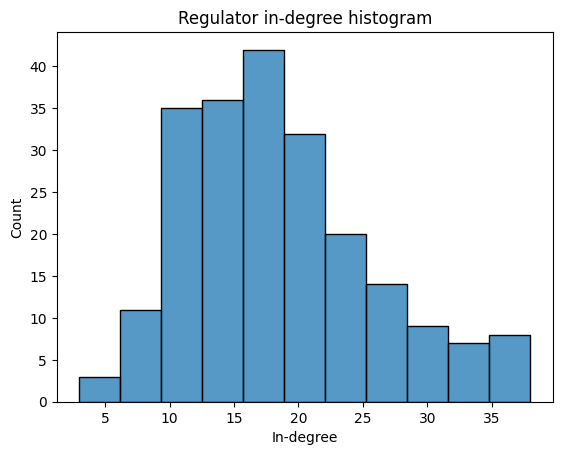

In [385]:
ax = sns.histplot(distenriched3_node_df.loc[distenriched3_node_df['Regulator'], 'InDegree'])
ax.set_xlabel('In-degree')
plt.title('Regulator in-degree histogram');

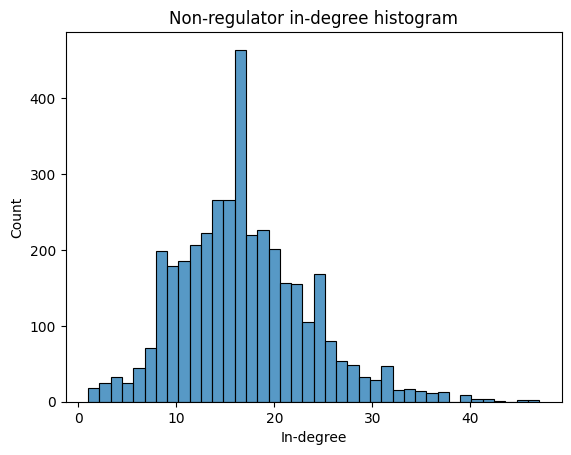

In [386]:
ax = sns.histplot(distenriched3_node_df.loc[~distenriched3_node_df['Regulator'], 'InDegree'])
ax.set_xlabel('In-degree')
plt.title('Non-regulator in-degree histogram');

In [387]:
for node, degree in distenriched3_g.degree():
    distenriched3_node_df.at[node, 'Degree'] = degree

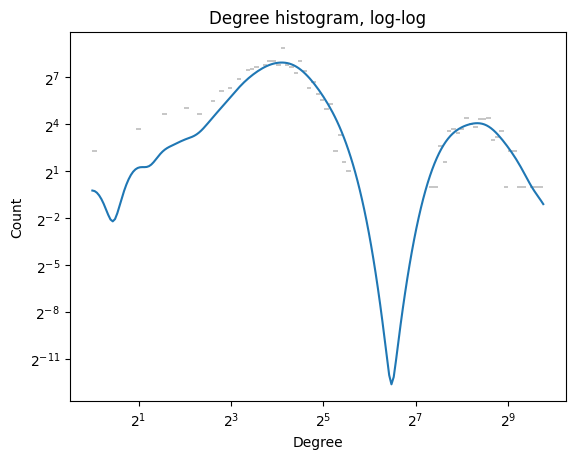

In [388]:
ax = sns.histplot(distenriched3_node_df['Degree'], kde=True, log_scale=[2, 2])
ax.set_xlabel('Degree')
plt.title('Degree histogram, log-log');

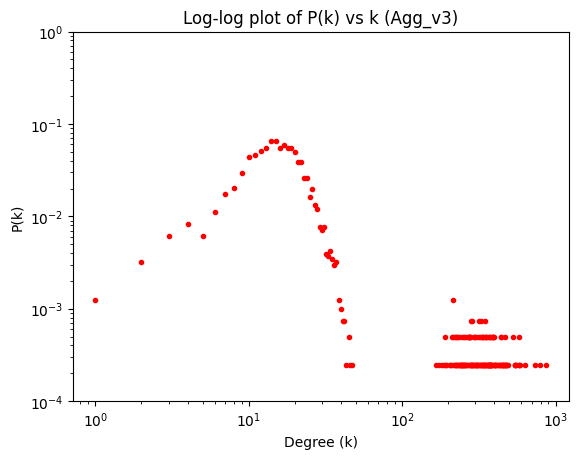

In [390]:
# Calculate degree sequences and frequency
distenriched3_degrees = np.array([distenriched3_g.degree(n) for n in distenriched3_g.nodes()])
distenriched3_degree_counts = np.bincount(distenriched3_degrees)
distenriched3_degrees = np.arange(len(distenriched3_degree_counts))

mask = distenriched3_degree_counts > 0
plt.loglog(distenriched3_degrees[mask], distenriched3_degree_counts[mask] / len(distenriched3_node_df), '.r')
plt.xlabel('Degree (k)')
plt.ylabel('P(k)')
plt.title('Log-log plot of P(k) vs k (Agg_v3)')
plt.ylim(1e-4, 1);  # Assuming you want to start at 1e-4 and end at 1 for P(k)
# plt.xlim(1, 100)

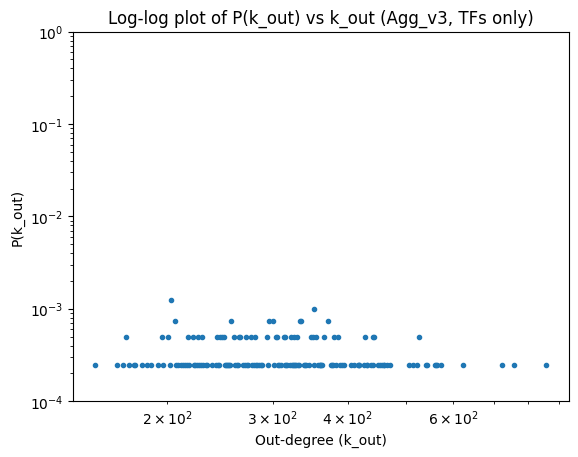

In [391]:
# Calculate degree sequences and frequency
distenriched3_degrees = np.array([distenriched3_g.out_degree(n) for n in distenriched3_g.nodes()])
distenriched3_degree_counts = np.bincount(distenriched3_degrees)
distenriched3_degrees = np.arange(len(distenriched3_degree_counts))

mask = distenriched3_degree_counts > 0
plt.loglog(distenriched3_degrees[mask], distenriched3_degree_counts[mask] / len(distenriched3_node_df), color='tab:blue', linestyle='', marker='.')
plt.xlabel('Out-degree (k_out)')
plt.ylabel('P(k_out)')
plt.title('Log-log plot of P(k_out) vs k_out (Agg_v3, TFs only)')
plt.ylim(1e-4, 1);  # Assuming you want to start at 1e-4 and end at 1 for P(k)
# plt.xlim(1, 100)

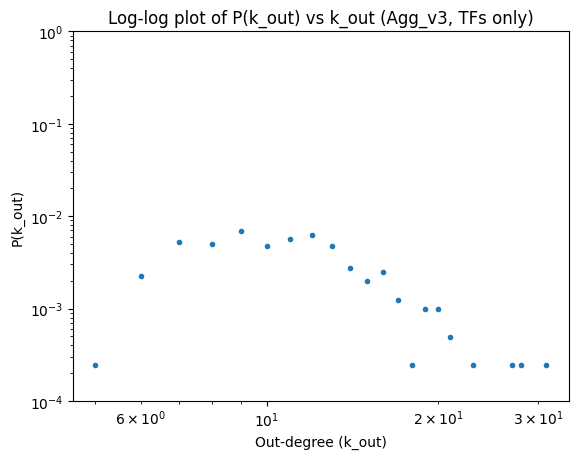

In [392]:
# Calculate degree sequences and frequency
distenriched3_degrees = np.array([distenriched3_g.out_degree(n) for n in distenriched3_g.nodes()])
# distenriched3_degree_counts = np.bincount(distenriched3_degrees)
distenriched3_degree_counts, bin_edges = np.histogram(distenriched3_degrees, bins=32)
distenriched3_degrees = np.arange(len(distenriched3_degree_counts))

mask = distenriched3_degree_counts > 0
plt.loglog(distenriched3_degrees[mask], distenriched3_degree_counts[mask] / len(distenriched3_node_df), color='tab:blue', linestyle='', marker='.')
plt.xlabel('Out-degree (k_out)')
plt.ylabel('P(k_out)')
plt.title('Log-log plot of P(k_out) vs k_out (Agg_v3, TFs only)')
plt.ylim(1e-4, 1);  # Assuming you want to start at 1e-4 and end at 1 for P(k)
# plt.xlim(1, 100)

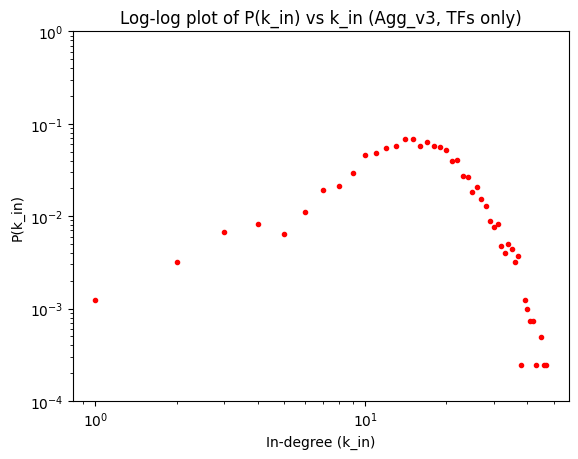

In [393]:
# Calculate degree sequences and frequency
distenriched3_degrees = np.array([distenriched3_g.in_degree(n) for n in distenriched3_g.nodes()])
distenriched3_degree_counts = np.bincount(distenriched3_degrees)
distenriched3_degrees = np.arange(len(distenriched3_degree_counts))

mask = distenriched3_degree_counts > 0
plt.loglog(distenriched3_degrees[mask], distenriched3_degree_counts[mask] / len(distenriched3_node_df), '.r')
plt.xlabel('In-degree (k_in)')
plt.ylabel('P(k_in)')
plt.title('Log-log plot of P(k_in) vs k_in (Agg_v3, TFs only)')
plt.ylim(1e-4, 1);  # Assuming you want to start at 1e-4 and end at 1 for P(k)
# plt.xlim(1, 100)

In [66]:
print('Mtb genes in annotation with no connections in this network:')
print(distenriched3_node_df['Degree'].isna().__or__(distenriched3_node_df['Degree'].eq(0)).sum())
distenriched3_node_df[distenriched3_node_df['Degree'].isna().__or__(distenriched3_node_df['Degree'].eq(0))].index.to_list()

Mtb genes in annotation with no connections in this network:
4


['Rv1954A', 'Rv1755c', 'Rv2998A', 'Rv0277A']

## Small-world-ness

In [396]:
distenriched3_g3 = distenriched3_g.copy()
distenriched3_g3.remove_nodes_from(
    distenriched3_node_df[distenriched3_node_df['Degree'].isna() | distenriched3_node_df['Degree'].eq(0)].index.to_list()
)

In [ ]:
# From Fred Mast PABIO536 notebook
# "Small-World Network (0<p<1, n>>k>>ln(n)>>1)"
# n = num nodes, k = num edges per node

In [397]:
print('n:', len(distenriched3_g3.nodes()))
print('k:', len(distenriched3_g3.edges()) / len(distenriched3_g3.nodes()))
print('ln(n):', np.log(len(distenriched3_g3.nodes())))

n: 4027
k: 16.942140551278868
ln(n): 8.300776960851454


In [398]:
# "In the context of small-world networks, one of the significant traits is a small characteristic path length"

# try:
#     lp = nx.average_shortest_path_length(distenriched3_g)
#     print(lp)
# except nx.NetworkXError as nxe:
#     print(nxe.args)

# can't use nx.average_shortest_path_length because the graph is not strongly connected
# see https://en.wikipedia.org/wiki/Average_path_length#Definition
def average_shortest_path_length(graph):
    # nodes_count = len(graph.nodes())
    sum_shortest_path_lengths = 0
    sum_shortest_path_lengths = sum(sum(target_lengths.values()) for source, target_lengths in nx.shortest_path_length(graph))
    relevant_nodes_count = len(list(nx.shortest_path_length(graph)))
    # return sum_shortest_path_lengths / (nodes_count * (nodes_count - 1))
    return sum_shortest_path_lengths / (relevant_nodes_count * (relevant_nodes_count - 1))

lp = average_shortest_path_length(distenriched3_g3)
print(lp)

0.11941630704123224


In [399]:
def average_shortest_path_length2(graph):
    # subgraphs = [subgraph for subgraph in nx.connected_component_subgraphs(graph) if len(subgraph) > 1]
    subgraphs = [graph.subgraph(node_set) for node_set in nx.strongly_connected_components(graph) if len(node_set) > 1]
    if len(subgraphs) == 0:
        raise ValueError('Supplied graph has no strongly connected subgraphs')
    total_subgraph_nodes = sum(len(sg) for sg in subgraphs)
    print(f'Returning average shortest path length for {total_subgraph_nodes} subgraph nodes (out of {len(graph.nodes())} total in supplied graph)')
    return math.fsum(len(sg) * nx.average_shortest_path_length(sg) for sg in subgraphs) / sum(len(sg) for sg in subgraphs)

lp = average_shortest_path_length2(distenriched3_g)
print(lp)

Returning average shortest path length for 214 subgraph nodes (out of 4027 total in supplied graph)
2.2174103812908603


# Analyze Regulators

In [10]:
distenriched3_directed_df = pd.read_csv(
    'aggregate-mtb_candidate_v3_directed.txt',
    sep='\t', index_col=False, names=['Regulator', 'Gene', 'Rank', 'Direction', 'Direction-details'])
print(distenriched3_directed_df.shape)
distenriched3_directed_df.head()

(68226, 5)


Regulator     Gene  Rank Direction Direction-details
0    Rv1657   Rv1659     1        up     up/up/up/up/-
1    Rv1657   Rv1658     2        up       up/up/-/-/-
2   Rv3249c  Rv3250c     3        up        up/-/-/-/-
3    Rv0081   Rv0085     4      both    up/down/up/-/-
4   Rv3417c   Rv0440     5        up     up/-/-/down/-

## Directionality

In [11]:
regulator_analysis_df = pd.DataFrame(index=regulators_df[0])
regulator_analysis_df['Name'] = regulator_analysis_df.index.map(annotation_df2['Name'])
regulator_analysis_df['Edges'] = distenriched3_directed_df.groupby('Regulator')['Gene'].count()
print(regulator_analysis_df.shape)
regulator_analysis_df.head()

(214, 2)


Name  Edges
0                     
Rv0019c    fhaB    361
Rv0020c    fhaA    513
Rv0022c   whiB5    327
Rv0023   Rv0023    251
Rv0038   Rv0038    203

In [12]:
distenriched3_directed_df.groupby('Regulator').value_counts(subset=['Direction'])

Regulator  Direction       
Rv0019c    up                  122
           up; maybe both       77
           both                 56
           down                 54
           down; maybe both     52
                              ... 
Rv3911     up                  276
           unknown              70
           down                 64
           up; maybe both       11
           both                  7
Name: count, Length: 1212, dtype: int64

In [13]:
direction_counts = distenriched3_directed_df.groupby(
    'Regulator'
).value_counts(
    subset=['Direction']
).reset_index(
    level='Direction', drop=False
).pivot(
    columns='Direction'
)

regulator_analysis_df[direction_counts.columns.droplevel(level=0)] = direction_counts
regulator_analysis_df.head()

Name  Edges  both  down  down; maybe both  unknown     up  \
0                                                                      
Rv0019c    fhaB    361  56.0  54.0              52.0      NaN  122.0   
Rv0020c    fhaA    513   6.0  92.0               NaN     52.0  354.0   
Rv0022c   whiB5    327  23.0  58.0               9.0     26.0  192.0   
Rv0023   Rv0023    251  26.0  46.0               1.0     42.0  127.0   
Rv0038   Rv0038    203   4.0  42.0               1.0     47.0  107.0   

         up; maybe both  
0                        
Rv0019c            77.0  
Rv0020c             9.0  
Rv0022c            19.0  
Rv0023              9.0  
Rv0038              2.0

In [14]:
regulator_analysis_df['mean_rank'] = distenriched3_directed_df.groupby('Regulator')['Rank'].mean()
regulator_analysis_df['mean_rank'].describe()

count      214.00
mean     35016.25
std       5117.27
min      21211.98
25%      31532.66
50%      34900.25
75%      38396.98
max      48499.05
Name: mean_rank, dtype: float64

In [15]:
# view mean rank outliers -- i.e. which regulators show up as relatively most and least confident (low ranks = high confidence)
regulator_analysis_df[
    regulator_analysis_df['mean_rank'].lt(regulator_analysis_df['mean_rank'].mean() - regulator_analysis_df['mean_rank'].std()*2) |
        regulator_analysis_df['mean_rank'].gt(regulator_analysis_df['mean_rank'].mean() + regulator_analysis_df['mean_rank'].std()*2)
].sort_values('mean_rank')

Name  Edges  both   down  down; maybe both  unknown     up  \
0                                                                        
Rv1267c     embR    394   2.0   42.0               4.0     79.0  254.0   
Rv0823c  Rv0823c    564   5.0  173.0               3.0     69.0  307.0   
Rv3414c     sigD    203   NaN   39.0               NaN     26.0  135.0   
Rv0452    Rv0452    521  13.0  135.0              18.0     83.0  252.0   
Rv1151c  Rv1151c    222   2.0   64.0               NaN     49.0  105.0   
Rv1167c  Rv1167c    260   2.0   68.0               1.0     67.0  119.0   
Rv2175c  Rv2175c    313   3.0   77.0               1.0     68.0  159.0   
Rv0757      phoP    214   8.0   71.0               2.0     45.0   86.0   
Rv0067c  Rv0067c    229   2.0   67.0               NaN     49.0  109.0   

         up; maybe both  mean_rank  
0                                   
Rv1267c            13.0   21211.98  
Rv0823c             7.0   22538.17  
Rv3414c             3.0   23071.32  
Rv0452             20.0   23286.73  
Rv1151c             2.0   45621.86  
Rv1167c             3.0   46142.82  
Rv2175c             5.0   46460.29  
Rv0757              2.0   47970.71  
Rv0067c             2.0   48499.05

In [16]:
regulator_analysis_df['up/down'] = (
    regulator_analysis_df['up'].add(regulator_analysis_df['up; maybe both'], fill_value=0)
) / (
    regulator_analysis_df['down'].add(regulator_analysis_df['down; maybe both'], fill_value=0).replace(to_replace=0, value=np.nan) # to avoid div by 0
)

display(regulator_analysis_df['up/down'].describe())
print('NaN up/down (means down is unrepresented):', regulator_analysis_df['up/down'].isna().sum())

count    214.00
mean       2.70
std        1.93
min        0.79
25%        1.58
50%        2.10
75%        3.15
max       15.00
Name: up/down, dtype: float64

NaN up/down (means down is unrepresented): 0


In [17]:
# look at the outliers -- i.e. which regulators are lopsidedly upregulators (there are no lower outliers, as 2 std left of mean is negative)
regulator_analysis_df[
    regulator_analysis_df['up/down'].gt(regulator_analysis_df['up/down'].mean() + regulator_analysis_df['up/down'].std()*2)
].sort_values('up/down', ascending=False)

Name  Edges  both  down  down; maybe both  unknown     up  \
0                                                                       
Rv2610c     pimA    623   3.0  36.0               NaN     44.0  527.0   
Rv3692     moxR2    572   6.0  42.0               NaN     31.0  479.0   
Rv2488c  Rv2488c    543   2.0  36.0               1.0     78.0  410.0   
Rv0602c     tcrA    371   2.0  27.0               NaN     49.0  290.0   
Rv2258c  Rv2258c    857   3.0  74.0               NaN     75.0  692.0   
Rv1453    Rv1453    385   4.0  32.0               1.0     39.0  303.0   
Rv0339c  Rv0339c    561   5.0  56.0               1.0     70.0  422.0   
Rv1423      whiA    428   6.0  47.0               NaN     34.0  333.0   
Rv0674    Rv0674    326   7.0  35.0               1.0     37.0  241.0   

         up; maybe both  mean_rank  up/down  
0                                            
Rv2610c            13.0   24941.91    15.00  
Rv3692             14.0   28838.74    11.74  
Rv2488c            16.0   26865.69    11.51  
Rv0602c             3.0   26699.44    10.85  
Rv2258c            13.0   25810.81     9.53  
Rv1453              6.0   35516.64     9.36  
Rv0339c             7.0   28847.37     7.53  
Rv1423              8.0   34737.75     7.26  
Rv0674              5.0   34012.87     6.83

In [23]:
regulator_analysis_df.to_csv('aggregate-mtb_candidate_v3_regulators.txt', sep='\t')

## Gene Ontology

In [18]:
# https://github.com/tanghaibao/goatools, https://doi.org/10.1038%2Fs41598-018-28948-z
from goatools.utils import read_geneset as goa_readgenes
from goatools.obo_parser import GODag as Goa_oboreader
from goatools.anno.gaf_reader import GafReader as Goa_gafreader
from goatools.go_enrichment import GOEnrichmentStudy as Goa_enrichment

population_ids = set(annotation_df2['UniProt_AC'].unique())
mtb_obo_dag = Goa_oboreader('../../../Papers/go-basic.obo')
mtb_go_mapping = Goa_gafreader(
    '../../../Papers/Uniprot__30.M_tuberculosis_ATCC_25618.goa.txt',
    godag=mtb_obo_dag) # ATCC 25618 is H37Rv NR-123

# One of gene_ids, gene_loci, or gene_names must be supplied
def mtb_gene_ontology(gene_ids=None, gene_loci=None, gene_names=None, name='current'):
    if gene_ids is not None and gene_loci is not None and gene_names is not None: # don't rely on truthiness: may be a pd.Series
        raise ValueError('One of gene_ids, gene_loci, or gene_names must be supplied')
    elif sum(gene_set is not None for gene_set in (gene_ids, gene_loci, gene_names)) > 1:
        raise ValueError('Only one of gene_ids, gene_loci, or gene_names must be supplied')

    if gene_loci is not None:
        gene_ids = annotation_df2.loc[gene_loci, 'UniProt_AC']
    elif gene_names is not None:
        gene_ids = annotation_df2.set_index('Name').loc[gene_names, 'UniProt_AC']
    
    study_ids = set(gene_ids)
    print(f'Performing gene ontology on {len(study_ids)} genes (out of {len(population_ids)} total Mtb genes)')

    mtb_go_enrichment = Goa_enrichment(
        population_ids,
        mtb_go_mapping.get_id2gos(),
        mtb_obo_dag,
        alpha=0.05,
        methods=['fdr_tsbky'],
        pvalcalc='fisher_scipy_stats')

    results_named_tuples_list = mtb_go_enrichment.run_study_nts(study_ids, name=name)

    return pd.DataFrame(results_named_tuples_list)

../../../Papers/go-basic.obo: fmt(1.2) rel(2024-06-17) 45,494 Terms
HMS:0:00:00.359977  27,763 annotations READ: ../../../Papers/Uniprot__30.M_tuberculosis_ATCC_25618.goa.txt 


In [19]:
# test mtb_gene_ontology function
test_go_df = mtb_gene_ontology(
    gene_loci=distenriched3_directed_df.loc[
        distenriched3_directed_df['Regulator'].eq(regulator_analysis_df.index[0]) &
            distenriched3_directed_df['Direction'].isin(['up', 'up; maybe both']),
        'Gene'
    ],
    name=regulator_analysis_df.index[0] + '-up'
)
test_go_df = test_go_df[test_go_df['p_fdr_tsbky'] < 0.05]
print(test_go_df.shape)
test_go_df.head()

Performing gene ontology on 199 genes (out of 3984 total Mtb genes)
3364 IDs in loaded association branch, biological_process

Load  Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 84%  3,350 of  3,984 population items found in association

Runing  Ontology Analysis: Rv0019c-up study set of 199 IDs.
 89%    177 of    199 study items found in association
100%    199 of    199 study items found in population(3984)
Calculating 3,925 uncorrected p-values using fisher_scipy_stats
   3,925 terms are associated with  3,350 of  3,984 population items
   1,051 terms are associated with    177 of    199 study items
  METHOD fdr_tsbky:
      21 GO terms found significant (< 0.05=alpha) ( 20 enriched +   1 purified): statsmodels fdr_tsbky
     140 study items associated with significant GO IDs (enriched)
       8 study items associated with significant GO IDs (purified)
(21, 25)


GO  NS enrichment                                          name  \
0  GO:1901566  BP          e  organonitrogen compound biosynthetic process   
1  GO:1901564  BP          e     organonitrogen compound metabolic process   
2  GO:0009058  BP          e                          biosynthetic process   
3  GO:0008152  BP          e                             metabolic process   
4  GO:0044237  BP          e                    cellular metabolic process   

  ratio_in_study  ratio_in_pop  p_uncorrected  depth  study_count  \
0      (52, 199)   (426, 3984)       3.13e-10      3           52   
1      (67, 199)   (649, 3984)       6.52e-10      2           67   
2      (70, 199)   (778, 3984)       1.06e-07      2           70   
3     (110, 199)  (1492, 3984)       1.71e-07      1          110   
4      (76, 199)   (978, 3984)       1.36e-05      2           76   

   p_fdr_tsbky  ... pop_n                                             goterm  \
0     1.28e-06  ...  3984  GO:1901566\tlevel-03\tdepth-03\torganonitrogen...   
1     1.34e-06  ...  3984  GO:1901564\tlevel-02\tdepth-02\torganonitrogen...   
2     1.45e-04  ...  3984  GO:0009058\tlevel-02\tdepth-02\tbiosynthetic p...   
3     1.75e-04  ...  3984  GO:0008152\tlevel-01\tdepth-01\tmetabolic proc...   
4     1.11e-02  ...  3984  GO:0044237\tlevel-02\tdepth-02\tcellular metab...   

           id     item_id           namespace  \
0  GO:1901566  GO:1901566  biological_process   
1  GO:1901564  GO:1901564  biological_process   
2  GO:0009058  GO:0009058  biological_process   
3  GO:0008152  GO:0008152  biological_process   
4  GO:0044237  GO:0044237  biological_process   

                                             parents  \
0  {GO:1901564\tlevel-02\tdepth-02\torganonitroge...   
1  {GO:0008152\tlevel-01\tdepth-01\tmetabolic pro...   
2  {GO:0008152\tlevel-01\tdepth-01\tmetabolic pro...   
3  {GO:0008150\tlevel-00\tdepth-00\tbiological_pr...   
4  {GO:0008152\tlevel-01\tdepth-01\tmetabolic pro...   

                                            children level is_obsolete  \
0  {GO:0009309\tlevel-04\tdepth-04\tamine biosynt...     3       False   
1  {GO:0009308\tlevel-03\tdepth-03\tamine metabol...     2       False   
2  {GO:0042179\tlevel-03\tdepth-03\tnicotine bios...     2       False   
3  {GO:0071941\tlevel-02\tdepth-02\tnitrogen cycl...     1       False   
4  {GO:0042180\tlevel-03\tdepth-03\tcellular keto...     2       False   

                    alt_ids  
0                        {}  
1                        {}  
2  {GO:0044711, GO:0044274}  
3  {GO:0044710, GO:0044236}  
4                        {}  

[5 rows x 25 columns]

In [20]:
go_dfs = []

directions = {
    'up': ['up', 'up; maybe both'],
    'down': ['down', 'down; maybe both'],
    'both': ['both', 'up; maybe both', 'down; maybe both'],
}

for regulator in regulator_analysis_df.index:
    for major_direction, minor_directions in directions.items():
        gene_loci = distenriched3_directed_df.loc[
            distenriched3_directed_df['Regulator'].eq(regulator) &
                distenriched3_directed_df['Direction'].isin(minor_directions),
            'Gene'
        ]
        if len(gene_loci) == 0:
            continue
        go_df = mtb_gene_ontology(gene_loci=gene_loci, name=f'{regulator}-{major_direction}')
        go_df.drop(index=go_df[go_df['p_uncorrected'].ge(0.05)].index, inplace=True)
        go_df.insert(0, 'Regulator', regulator)
        go_df.insert(1, 'Direction', major_direction)
        go_dfs.append(go_df)

master_go_df = pd.concat(go_dfs)
print(master_go_df.shape)
master_go_df.head()

Performing gene ontology on 199 genes (out of 3984 total Mtb genes)
3364 IDs in loaded association branch, biological_process

Load  Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 84%  3,350 of  3,984 population items found in association

Runing  Ontology Analysis: Rv0019c-up study set of 199 IDs.
 89%    177 of    199 study items found in association
100%    199 of    199 study items found in population(3984)
Calculating 3,925 uncorrected p-values using fisher_scipy_stats
   3,925 terms are associated with  3,350 of  3,984 population items
   1,051 terms are associated with    177 of    199 study items
  METHOD fdr_tsbky:
      21 GO terms found significant (< 0.05=alpha) ( 20 enriched +   1 purified): statsmodels fdr_tsbky
     140 study items associated with significant GO IDs (enriched)
       8 study items associated with significant GO IDs (purified)
Performing gene ontology on 106 genes (out of 3984 total Mtb genes)
3364 IDs in loaded association branch, bio

Regulator Direction          GO  NS enrichment  \
0   Rv0019c        up  GO:1901566  BP          e   
1   Rv0019c        up  GO:1901564  BP          e   
2   Rv0019c        up  GO:0009058  BP          e   
3   Rv0019c        up  GO:0008152  BP          e   
4   Rv0019c        up  GO:0044237  BP          e   

                                           name ratio_in_study  ratio_in_pop  \
0  organonitrogen compound biosynthetic process      (52, 199)   (426, 3984)   
1     organonitrogen compound metabolic process      (67, 199)   (649, 3984)   
2                          biosynthetic process      (70, 199)   (778, 3984)   
3                             metabolic process     (110, 199)  (1492, 3984)   
4                    cellular metabolic process      (76, 199)   (978, 3984)   

   p_uncorrected  depth  ...  pop_n  \
0       3.13e-10      3  ...   3984   
1       6.52e-10      2  ...   3984   
2       1.06e-07      2  ...   3984   
3       1.71e-07      1  ...   3984   
4       1.36e-05      2  ...   3984   

                                              goterm          id     item_id  \
0  GO:1901566\tlevel-03\tdepth-03\torganonitrogen...  GO:1901566  GO:1901566   
1  GO:1901564\tlevel-02\tdepth-02\torganonitrogen...  GO:1901564  GO:1901564   
2  GO:0009058\tlevel-02\tdepth-02\tbiosynthetic p...  GO:0009058  GO:0009058   
3  GO:0008152\tlevel-01\tdepth-01\tmetabolic proc...  GO:0008152  GO:0008152   
4  GO:0044237\tlevel-02\tdepth-02\tcellular metab...  GO:0044237  GO:0044237   

            namespace                                            parents  \
0  biological_process  {GO:1901564\tlevel-02\tdepth-02\torganonitroge...   
1  biological_process  {GO:0008152\tlevel-01\tdepth-01\tmetabolic pro...   
2  biological_process  {GO:0008152\tlevel-01\tdepth-01\tmetabolic pro...   
3  biological_process  {GO:0008150\tlevel-00\tdepth-00\tbiological_pr...   
4  biological_process  {GO:0008152\tlevel-01\tdepth-01\tmetabolic pro...   

                                            children  level is_obsolete  \
0  {GO:0009309\tlevel-04\tdepth-04\tamine biosynt...      3       False   
1  {GO:0009308\tlevel-03\tdepth-03\tamine metabol...      2       False   
2  {GO:0042179\tlevel-03\tdepth-03\tnicotine bios...      2       False   
3  {GO:0071941\tlevel-02\tdepth-02\tnitrogen cycl...      1       False   
4  {GO:0042180\tlevel-03\tdepth-03\tcellular keto...      2       False   

                    alt_ids  
0                        {}  
1                        {}  
2  {GO:0044711, GO:0044274}  
3  {GO:0044710, GO:0044236}  
4                        {}  

[5 rows x 27 columns]

### Multiple test correction

In [21]:
reject_null, master_go_df['p_fdr_tsbky_all'], alphac_Sidak, alphac_Bonf = statsmodels.stats.multitest.multipletests(
    master_go_df['p_uncorrected'], alpha=0.05, method='fdr_tsbky', is_sorted=False)

master_go_df2 = master_go_df[reject_null].copy()
print(master_go_df2.shape)

(59845, 28)


In [22]:
master_go_df2[['p_uncorrected', 'p_fdr_tsbky', 'p_fdr_tsbky_all']].describe()
# display(master_go_df2['p_adj'].describe())
# master_go_df2.columns

p_uncorrected  p_fdr_tsbky  p_fdr_tsbky_all
count       5.98e+04     5.98e+04         5.98e+04
mean        2.15e-02     7.91e-01         5.59e-03
std         1.55e-02     3.31e-01         2.32e-03
min         8.04e-34     3.15e-30         7.65e-30
25%         6.76e-03     6.57e-01         4.29e-03
50%         2.08e-02     1.00e+00         6.60e-03
75%         3.46e-02     1.00e+00         7.32e-03
max         5.00e-02     1.00e+00         7.94e-03

That's.... weird. `p_fdr_tsbky_all` should be calculated in the same way as `p_fdr_tsbky`, only on a larger set -- which I thought would lead to more rejections. Instead, it seems like `p_fdr_tsbky_all` has actually _increased_ the significance level of the uncorrected p-values?

Going to look this up a bit.... Can't really find anything relevant. :/

In [151]:
reject_null2, master_go_df['p_fdr_tsbky_adj'], alphac_Sidak2, alphac_Bonf2 = statsmodels.stats.multitest.multipletests(
    master_go_df['p_fdr_tsbky'], alpha=0.05, method='fdr_tsbky', is_sorted=False)

print(master_go_df[reject_null2].shape)

reject_null3, master_go_df['p_bonferroni'], alphac_Sidak2, alphac_Bonf2 = statsmodels.stats.multitest.multipletests(
    master_go_df['p_uncorrected'], alpha=0.05, method='bonferroni', is_sorted=False)

print(master_go_df[reject_null3].shape)

reject_null4, master_go_df['p_fdr_bh_all'], alphac_Sidak2, alphac_Bonf2 = statsmodels.stats.multitest.multipletests(
    master_go_df['p_uncorrected'], alpha=0.05, method='fdr_bh', is_sorted=False)

print(master_go_df[reject_null4].shape)

(1461, 31)
(1101, 31)
(59845, 32)


In [152]:
master_go_df[['p_uncorrected', 'p_fdr_tsbky', 'p_fdr_tsbky_all', 'p_fdr_tsbky_adj', 'p_bonferroni', 'p_fdr_bh_all']].describe()

p_uncorrected  p_fdr_tsbky  p_fdr_tsbky_all  p_fdr_tsbky_adj  \
count       5.98e+04     5.98e+04         5.98e+04         5.98e+04   
mean        2.15e-02     7.91e-01         5.59e-03         9.52e-01   
std         1.55e-02     3.31e-01         2.32e-03         1.96e-01   
min         8.04e-34     3.15e-30         7.65e-30         1.93e-25   
25%         6.76e-03     6.57e-01         4.29e-03         1.00e+00   
50%         2.08e-02     1.00e+00         6.60e-03         1.00e+00   
75%         3.46e-02     1.00e+00         7.32e-03         1.00e+00   
max         5.00e-02     1.00e+00         7.94e-03         1.00e+00   

       p_bonferroni  p_fdr_bh_all  
count      5.98e+04      5.98e+04  
mean       9.74e-01      3.52e-02  
std        1.53e-01      1.46e-02  
min        4.81e-29      4.81e-29  
25%        1.00e+00      2.70e-02  
50%        1.00e+00      4.16e-02  
75%        1.00e+00      4.61e-02  
max        1.00e+00      5.00e-02

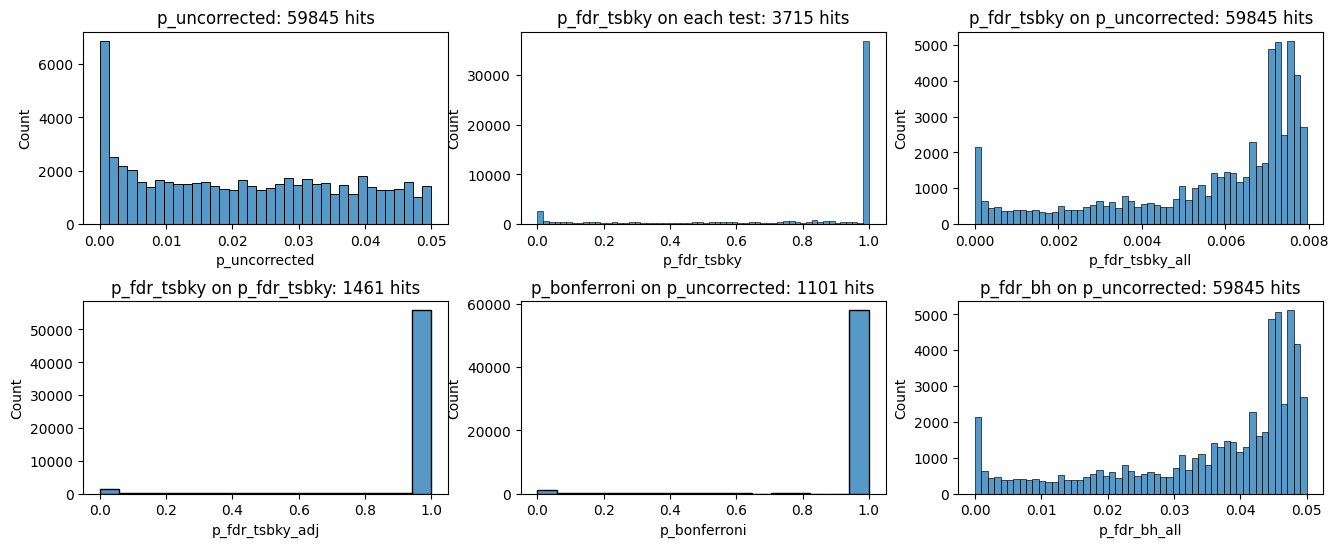

In [159]:
fig = plt.figure(figsize=(16, 6), dpi=100)
axs = fig.subplots(nrows=2, ncols=3, sharex=False, sharey=False, squeeze=True, gridspec_kw={'hspace': 0.4}).flatten()
threshold = 0.05

for i, method in enumerate(['p_uncorrected', 'p_fdr_tsbky', 'p_fdr_tsbky_all', 'p_fdr_tsbky_adj', 'p_bonferroni', 'p_fdr_bh_all']):
    ax = sns.histplot(master_go_df[method], ax=axs[i])
    if method == 'p_fdr_tsbky_adj':
        ax.set_title(f'p_fdr_tsbky on p_fdr_tsbky: {master_go_df[method].le(threshold).sum()} hits')
    elif method == 'p_fdr_tsbky':
        ax.set_title(f'p_fdr_tsbky on each test: {master_go_df[method].le(threshold).sum()} hits')
    elif method == 'p_fdr_tsbky_all':
        ax.set_title(f'p_fdr_tsbky on p_uncorrected: {master_go_df[method].le(threshold).sum()} hits')
    elif method == 'p_bonferroni':
        ax.set_title(f'p_bonferroni on p_uncorrected: {master_go_df[method].le(threshold).sum()} hits')
    elif method == 'p_fdr_bh_all':
        ax.set_title(f'p_fdr_bh on p_uncorrected: {master_go_df[method].le(threshold).sum()} hits')
    else:
        ax.set_title(f'{method}: {master_go_df[method].le(threshold).sum()} hits')

3881 hits


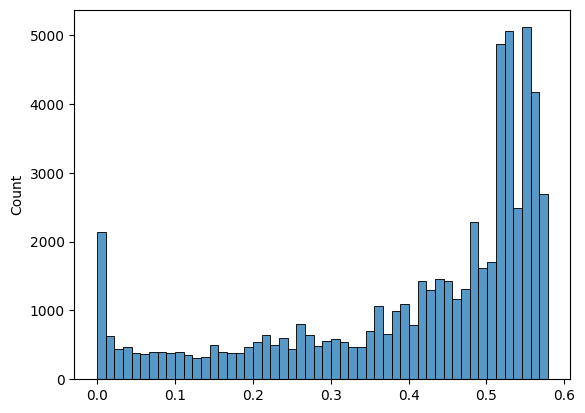

In [160]:
sns.histplot(
    statsmodels.stats.multitest.multipletests(
        master_go_df['p_uncorrected'], alpha=0.05, method='fdr_by', is_sorted=False)[1])
print(statsmodels.stats.multitest.multipletests(
        master_go_df['p_uncorrected'], alpha=0.05, method='fdr_by', is_sorted=False)[0].sum(), 'hits')

I think what's happening here is, I'm not supplying the FDR algorithms with all of the tested p-values -- I'm only giving it the "significant" p-values that the GO enrichment tests are giving me. And that's not what they properly take. But I don't know all the other p-values. So `p_fdr_tsbky_all` (FDR_tsbky run on all the `p_uncorrected`s), `p_fdr_tsbky_adj` (FDR_tsbky run on all the `p_fdr_tsbky`s), and `p_fdr_bh_all` (FDR_bh run on all the `p_uncorrected`s) are all erroneous. Even `p_bonferroni` is wrong, since it needs to know the total number of tests, and I don't know that either. And `p_uncorrected` is obviously uncorrected.

But, `p_fdr_tsbky` contains the false-discovery-rate-adjusted p-values, and combining all of those should maintain the same error rate, I think (and so does Braden). So I think if we just use `p_fdr_tsbky < 0.05` as our threshold, we should have only significant hits.

In [23]:
sgnfcnt_go_df = master_go_df.loc[master_go_df['p_fdr_tsbky'].lt(0.05), 'Regulator':'alt_ids'].reset_index(drop=True)
print(sgnfcnt_go_df.shape)
sgnfcnt_go_df.head()

(3715, 27)


Regulator Direction          GO  NS enrichment  \
0   Rv0019c        up  GO:1901566  BP          e   
1   Rv0019c        up  GO:1901564  BP          e   
2   Rv0019c        up  GO:0009058  BP          e   
3   Rv0019c        up  GO:0008152  BP          e   
4   Rv0019c        up  GO:0044237  BP          e   

                                           name ratio_in_study  ratio_in_pop  \
0  organonitrogen compound biosynthetic process      (52, 199)   (426, 3984)   
1     organonitrogen compound metabolic process      (67, 199)   (649, 3984)   
2                          biosynthetic process      (70, 199)   (778, 3984)   
3                             metabolic process     (110, 199)  (1492, 3984)   
4                    cellular metabolic process      (76, 199)   (978, 3984)   

   p_uncorrected  depth  ...  pop_n  \
0       3.13e-10      3  ...   3984   
1       6.52e-10      2  ...   3984   
2       1.06e-07      2  ...   3984   
3       1.71e-07      1  ...   3984   
4       1.36e-05      2  ...   3984   

                                              goterm          id     item_id  \
0  GO:1901566\tlevel-03\tdepth-03\torganonitrogen...  GO:1901566  GO:1901566   
1  GO:1901564\tlevel-02\tdepth-02\torganonitrogen...  GO:1901564  GO:1901564   
2  GO:0009058\tlevel-02\tdepth-02\tbiosynthetic p...  GO:0009058  GO:0009058   
3  GO:0008152\tlevel-01\tdepth-01\tmetabolic proc...  GO:0008152  GO:0008152   
4  GO:0044237\tlevel-02\tdepth-02\tcellular metab...  GO:0044237  GO:0044237   

            namespace                                            parents  \
0  biological_process  {GO:1901564\tlevel-02\tdepth-02\torganonitroge...   
1  biological_process  {GO:0008152\tlevel-01\tdepth-01\tmetabolic pro...   
2  biological_process  {GO:0008152\tlevel-01\tdepth-01\tmetabolic pro...   
3  biological_process  {GO:0008150\tlevel-00\tdepth-00\tbiological_pr...   
4  biological_process  {GO:0008152\tlevel-01\tdepth-01\tmetabolic pro...   

                                            children  level is_obsolete  \
0  {GO:0009309\tlevel-04\tdepth-04\tamine biosynt...      3       False   
1  {GO:0009308\tlevel-03\tdepth-03\tamine metabol...      2       False   
2  {GO:0042179\tlevel-03\tdepth-03\tnicotine bios...      2       False   
3  {GO:0071941\tlevel-02\tdepth-02\tnitrogen cycl...      1       False   
4  {GO:0042180\tlevel-03\tdepth-03\tcellular keto...      2       False   

                    alt_ids  
0                        {}  
1                        {}  
2  {GO:0044711, GO:0044274}  
3  {GO:0044710, GO:0044236}  
4                        {}  

[5 rows x 27 columns]

### Initial Analysis

In [213]:
sgnfcnt_go_df['Regulator'].value_counts()

Regulator
Rv2610c    294
Rv2215     222
Rv2258c    193
Rv0339c    192
Rv2703     125
          ... 
Rv0324       1
Rv0678       1
Rv2506       1
Rv2745c      1
Rv2621c      1
Name: count, Length: 134, dtype: int64

In [423]:
sgnfcnt_go_df['Regulator'].value_counts()[sgnfcnt_go_df['Regulator'].value_counts() > 2]

Regulator
Rv2610c    294
Rv2215     222
Rv2258c    193
Rv0339c    192
Rv2703     125
          ... 
Rv1776c      3
Rv2242       3
Rv0445c      3
Rv3416       3
Rv2912c      3
Name: count, Length: 112, dtype: int64

Ok, 134 out of 214 have a significant GO enrichment, and over half have at least 3 enrichments. That's cool.

Let's try to figure out what the most specific associations are -- right now we have a tree of associations, and I feel like the less specific ones are less valuable.

#### Get leaf GO annotations

In [214]:
sgnfcnt_go_df.columns

Index(['Regulator', 'Direction', 'GO', 'NS', 'enrichment', 'name',
       'ratio_in_study', 'ratio_in_pop', 'p_uncorrected', 'depth',
       'study_count', 'p_fdr_tsbky', 'study_items', 'kws', 'pop_items',
       'study_n', 'pop_count', 'pop_n', 'goterm', 'id', 'item_id', 'namespace',
       'parents', 'children', 'level', 'is_obsolete', 'alt_ids'],
      dtype='object')

In [24]:
sgnfcnt_go_df.insert(2, 'Activity', sgnfcnt_go_df['Regulator'].str.cat(sgnfcnt_go_df['Direction'], sep='_'))

In [25]:
# parents column is a set() of GOTerm objects
activity_parents = sgnfcnt_go_df.groupby('Activity')['parents'].agg(lambda parents: set().union(*parents))

sgnfcnt_go_df['Activity_parents'] = sgnfcnt_go_df['Activity'].map(activity_parents)

sgnfcnt_go_df['Activity_parents'].head()

0    {GO:0008152\tlevel-01\tdepth-01\tmetabolic pro...
1    {GO:0008152\tlevel-01\tdepth-01\tmetabolic pro...
2    {GO:0008152\tlevel-01\tdepth-01\tmetabolic pro...
3    {GO:0008152\tlevel-01\tdepth-01\tmetabolic pro...
4    {GO:0008152\tlevel-01\tdepth-01\tmetabolic pro...
Name: Activity_parents, dtype: object

In [26]:
sgnfcnt_go_df['Activity_parent'] = sgnfcnt_go_df.apply(
    lambda row: row['goterm'] in row['Activity_parents'],
    axis=1
)
sgnfcnt_go_df['Activity_parent'].head()

0    False
1     True
2     True
3     True
4     True
Name: Activity_parent, dtype: bool

In [27]:
sgnfcnt_leaf_go_df = sgnfcnt_go_df[~sgnfcnt_go_df['Activity_parent']].reset_index(drop=True)
print(sgnfcnt_leaf_go_df.shape)
sgnfcnt_leaf_go_df.head()

(1146, 30)


Regulator Direction    Activity          GO  NS enrichment  \
0   Rv0019c        up  Rv0019c_up  GO:1901566  BP          e   
1   Rv0019c        up  Rv0019c_up  GO:0043170  BP          e   
2   Rv0019c        up  Rv0019c_up  GO:0043650  BP          e   
3   Rv0019c        up  Rv0019c_up  GO:0044249  BP          e   
4   Rv0019c        up  Rv0019c_up  GO:0016070  BP          e   

                                           name ratio_in_study ratio_in_pop  \
0  organonitrogen compound biosynthetic process      (52, 199)  (426, 3984)   
1               macromolecule metabolic process      (50, 199)  (564, 3984)   
2        dicarboxylic acid biosynthetic process       (7, 199)   (21, 3984)   
3                 cellular biosynthetic process      (50, 199)  (580, 3984)   
4                         RNA metabolic process      (17, 199)  (120, 3984)   

   p_uncorrected  ...          id     item_id           namespace  \
0       3.13e-10  ...  GO:1901566  GO:1901566  biological_process   
1       2.39e-05  ...  GO:0043170  GO:0043170  biological_process   
2       4.46e-05  ...  GO:0043650  GO:0043650  biological_process   
3       4.96e-05  ...  GO:0044249  GO:0044249  biological_process   
4       7.49e-05  ...  GO:0016070  GO:0016070  biological_process   

                                             parents  \
0  {GO:1901564\tlevel-02\tdepth-02\torganonitroge...   
1  {GO:0008152\tlevel-01\tdepth-01\tmetabolic pro...   
2  {GO:0043648\tlevel-06\tdepth-06\tdicarboxylic ...   
3  {GO:0044237\tlevel-02\tdepth-02\tcellular meta...   
4  {GO:0090304\tlevel-03\tdepth-04\tnucleic acid ...   

                                            children level  is_obsolete  \
0  {GO:0009309\tlevel-04\tdepth-04\tamine biosynt...     3        False   
1  {GO:0046377\tlevel-03\tdepth-03\tcolanic acid ...     2        False   
2  {GO:0009423\tlevel-07\tdepth-08\tchorismate bi...     6        False   
3  {GO:0043447\tlevel-04\tdepth-04\talkane biosyn...     3        False   
4  {GO:0016074\tlevel-05\tdepth-06\tsno(s)RNA met...     4        False   

                                alt_ids  \
0                                    {}   
1  {GO:0044259, GO:0034960, GO:0043283}   
2                                    {}   
3                                    {}   
4                                    {}   

                                    Activity_parents Activity_parent  
0  {GO:0008152\tlevel-01\tdepth-01\tmetabolic pro...           False  
1  {GO:0008152\tlevel-01\tdepth-01\tmetabolic pro...           False  
2  {GO:0008152\tlevel-01\tdepth-01\tmetabolic pro...           False  
3  {GO:0008152\tlevel-01\tdepth-01\tmetabolic pro...           False  
4  {GO:0008152\tlevel-01\tdepth-01\tmetabolic pro...           False  

[5 rows x 30 columns]

In [28]:
sgnfcnt_leaf_go_df['Regulator'].value_counts()

Regulator
Rv0339c    64
Rv2610c    64
Rv2258c    56
Rv2215     51
Rv2703     41
           ..
Rv0891c     1
Rv1176c     1
Rv1027c     1
Rv2711      1
Rv0472c     1
Name: count, Length: 134, dtype: int64

Good. Same number of regulators -- we didn't filter out regulators, we only filtered down the GO annotations associated with each regulator.

In [29]:
sgnfcnt_leaf_go_df['Activity'].value_counts()

Activity
Rv2610c_up      64
Rv0339c_up      61
Rv2258c_up      56
Rv2215_up       49
Rv2703_up       41
                ..
Rv0491_up        1
Rv3133c_up       1
Rv0485_both      1
Rv0981_down      1
Rv0019c_down     1
Name: count, Length: 175, dtype: int64

#### Write to file

In [225]:
# drop complex info that won't present well in spreadsheet, and export to file
sgnfcnt_leaf_go_df.drop(
    columns=[
        'Activity',
        'study_items', 'kws', 'pop_items', 'goterm', 'id', 'item_id', 'parents', 'children', 'is_obsolete', 'alt_ids',
        'Activity_parents', 'Activity_parent',
    ]
).to_csv(
    'significant_regulator_leafGO_assoc.csv',
    sep=',', index=False,
)

#### Get list of named TFs with significant ontologies

In [355]:
annotation_df.loc[
    ~annotation_df['Name'].str.startswith('Rv') &
        annotation_df['Locus'].isin(regulators_df[0]),
    'Locus'
]

328     Rv0445c
385     Rv0599c
436      Rv0757
458     Rv0821c
464     Rv0844c
         ...   
4036     Rv3692
4081     Rv3852
4128     Rv3849
4144     Rv3855
4151    Rv3862c
Name: Locus, Length: 85, dtype: object

In [340]:
# find TFs with (1) more than two significant leaf ontologies, that (2) are named
named_leaf_tfs = sgnfcnt_leaf_go_df.loc[
    sgnfcnt_leaf_go_df['Regulator'].isin(
        annotation_df.loc[~annotation_df['Name'].str.startswith('Rv'), 'Locus']
    ),
    'Regulator'
].unique()
print(len(named_leaf_tfs), 'named TFs with leaf GO:', ', '.join(named_tfs))
print()

named_mult_leaf_go_tfs = sgnfcnt_leaf_go_df.loc[
    sgnfcnt_leaf_go_df['Regulator'].isin(named_leaf_tfs) &
        sgnfcnt_leaf_go_df['Activity'].map(sgnfcnt_leaf_go_df['Activity'].value_counts().gt(2)),
    'Regulator'
].unique()
print(len(named_mult_leaf_go_tfs), 'named TFs with multiple leaf GO:', ', '.join(named_mult_leaf_go_tfs))
print()

sgnfcnt_named_leaf_go_df = sgnfcnt_leaf_go_df[
    sgnfcnt_leaf_go_df['Regulator'].isin(named_mult_leaf_go_tfs)
].reset_index(drop=True)
sgnfcnt_named_leaf_go_df.insert(3, 'TfName', sgnfcnt_named_leaf_go_df['Regulator'].map(annotation_df2['Name']))
print(sgnfcnt_named_leaf_go_df.shape)
sgnfcnt_named_leaf_go_df.head()

62 named TFs with leaf GO: Rv0019c, Rv0020c, Rv0022c, Rv0054, Rv0165c, Rv0182c, Rv0212c, Rv0353, Rv0445c, Rv0491, Rv0599c, Rv0602c, Rv0608, Rv0623, Rv0827c, Rv0844c, Rv0967, Rv0981, Rv1027c, Rv1189, Rv1221, Rv1379, Rv1423, Rv1560, Rv1657, Rv1740, Rv1846c, Rv1909c, Rv1960c, Rv1994c, Rv2009, Rv2069, Rv2215, Rv2359, Rv2374c, Rv2595, Rv2610c, Rv2703, Rv2710, Rv2711, Rv2720, Rv2745c, Rv2760c, Rv2986c, Rv3082c, Rv3124, Rv3133c, Rv3219, Rv3223c, Rv3246c, Rv3260c, Rv3301c, Rv3328c, Rv3414c, Rv3416, Rv3417c, Rv3574, Rv3597c, Rv3676, Rv3692, Rv3852, Rv3862c

46 named TFs with multiple leaf GO: Rv0019c, Rv0020c, Rv0022c, Rv0054, Rv0165c, Rv0182c, Rv0212c, Rv0353, Rv0599c, Rv0602c, Rv0608, Rv0623, Rv0967, Rv1221, Rv1379, Rv1423, Rv1560, Rv1657, Rv1740, Rv1909c, Rv1960c, Rv1994c, Rv2009, Rv2069, Rv2215, Rv2359, Rv2374c, Rv2595, Rv2610c, Rv2703, Rv2710, Rv2720, Rv2760c, Rv2986c, Rv3082c, Rv3124, Rv3219, Rv3246c, Rv3301c, Rv3414c, Rv3417c, Rv3574, Rv3597c, Rv3692, Rv3852, Rv3862c

(608, 31)


Regulator Direction    Activity TfName          GO  NS enrichment  \
0   Rv0019c        up  Rv0019c_up   fhaB  GO:1901566  BP          e   
1   Rv0019c        up  Rv0019c_up   fhaB  GO:0043170  BP          e   
2   Rv0019c        up  Rv0019c_up   fhaB  GO:0043650  BP          e   
3   Rv0019c        up  Rv0019c_up   fhaB  GO:0044249  BP          e   
4   Rv0019c        up  Rv0019c_up   fhaB  GO:0016070  BP          e   

                                           name ratio_in_study ratio_in_pop  \
0  organonitrogen compound biosynthetic process      (52, 199)  (426, 3984)   
1               macromolecule metabolic process      (50, 199)  (564, 3984)   
2        dicarboxylic acid biosynthetic process       (7, 199)   (21, 3984)   
3                 cellular biosynthetic process      (50, 199)  (580, 3984)   
4                         RNA metabolic process      (17, 199)  (120, 3984)   

   ...          id     item_id           namespace  \
0  ...  GO:1901566  GO:1901566  biological_process   
1  ...  GO:0043170  GO:0043170  biological_process   
2  ...  GO:0043650  GO:0043650  biological_process   
3  ...  GO:0044249  GO:0044249  biological_process   
4  ...  GO:0016070  GO:0016070  biological_process   

                                             parents  \
0  {GO:0009058\tlevel-02\tdepth-02\tbiosynthetic ...   
1  {GO:0008152\tlevel-01\tdepth-01\tmetabolic pro...   
2  {GO:0046394\tlevel-05\tdepth-06\tcarboxylic ac...   
3  {GO:0044237\tlevel-02\tdepth-02\tcellular meta...   
4  {GO:0090304\tlevel-03\tdepth-04\tnucleic acid ...   

                                            children level is_obsolete  \
0  {GO:0042727\tlevel-04\tdepth-04\tflavin-contai...     3       False   
1  {GO:0005976\tlevel-03\tdepth-04\tpolysaccharid...     2       False   
2  {GO:0006537\tlevel-06\tdepth-10\tglutamate bio...     6       False   
3  {GO:0032923\tlevel-04\tdepth-06\torganic phosp...     3       False   
4  {GO:0000378\tlevel-05\tdepth-06\tRNA exon liga...     4       False   

                                alt_ids  \
0                                    {}   
1  {GO:0034960, GO:0044259, GO:0043283}   
2                                    {}   
3                                    {}   
4                                    {}   

                                    Activity_parents  Activity_parent  
0  {GO:0016740\tlevel-02\tdepth-02\ttransferase a...            False  
1  {GO:0016740\tlevel-02\tdepth-02\ttransferase a...            False  
2  {GO:0016740\tlevel-02\tdepth-02\ttransferase a...            False  
3  {GO:0016740\tlevel-02\tdepth-02\ttransferase a...            False  
4  {GO:0016740\tlevel-02\tdepth-02\ttransferase a...            False  

[5 rows x 31 columns]

In [430]:
sgnfcnt_named_leaf_go_tf_df = sgnfcnt_named_leaf_go_df.groupby('Activity').agg({
    'Regulator': 'max',
    'Direction': 'max',
    'TfName': 'max',
    'GO': 'count',
}).pivot(
    columns='Direction',
    index='Regulator',
    values='GO',
)
sgnfcnt_named_leaf_go_tf_df.insert(0, 'TfName', sgnfcnt_named_leaf_go_tf_df.index.map(annotation_df2['Name']))
sgnfcnt_named_leaf_go_tf_df['total'] = sgnfcnt_named_leaf_go_tf_df[['both', 'down', 'up']].sum(axis=1)
sgnfcnt_named_leaf_go_tf_df['mycb_function'] = sgnfcnt_named_leaf_go_tf_df.index.map(annotation_df2['Function'])
sgnfcnt_named_leaf_go_tf_df['mycb_product'] = sgnfcnt_named_leaf_go_tf_df.index.map(annotation_df2['Product'])
print(sgnfcnt_named_leaf_go_tf_df.shape)
sgnfcnt_named_leaf_go_tf_df.head()

(46, 7)


Direction TfName  both  down    up  total  \
Regulator                                   
Rv0019c     fhaB   NaN   1.0  13.0   14.0   
Rv0020c     fhaA   NaN   NaN  22.0   22.0   
Rv0022c    whiB5   NaN   NaN   3.0    3.0   
Rv0054       ssb   NaN   5.0   9.0   14.0   
Rv0165c    mce1R   NaN   NaN  13.0   13.0   

Direction                                      mycb_function  \
Regulator                                                      
Rv0019c                                  Signal transduction   
Rv0020c                                  Signal transduction   
Rv0022c               Involved in transcriptional mechanism.   
Rv0054     This protein is essential for replication of t...   
Rv0165c                Involved in transcriptional mechanism   

Direction                                       mycb_product  
Regulator                                                     
Rv0019c              Conserved protein with FHA domain, FhaB  
Rv0020c              Conserved protein with FHA domain, FhaA  
Rv0022c    Probable transcriptional regulatory protein Wh...  
Rv0054     Single-strand binding protein Ssb (helix-desta...  
Rv0165c    Probable transcriptional regulatory protein Mc...

In [431]:
sgnfcnt_named_leaf_go_tf_df.to_csv('proof_candidate_tfs.csv', sep=',')

#### And also all TFs with significant ontologies

In [31]:
# find TFs with (1) more than two significant leaf ontologies, that (2) are named
unnamed_leaf_tfs = sgnfcnt_leaf_go_df.loc[
    ~sgnfcnt_leaf_go_df['Regulator'].isin(
        annotation_df.loc[~annotation_df['Name'].str.startswith('Rv'), 'Locus']
    ),
    'Regulator'
].unique()
print(len(unnamed_leaf_tfs), 'unnamed TFs with leaf GO:', ', '.join(unnamed_leaf_tfs))
print()

unnamed_mult_leaf_go_tfs = sgnfcnt_leaf_go_df.loc[
    sgnfcnt_leaf_go_df['Regulator'].isin(unnamed_leaf_tfs) &
        sgnfcnt_leaf_go_df['Activity'].map(sgnfcnt_leaf_go_df['Activity'].value_counts().gt(2)),
    'Regulator'
].unique()
print(len(unnamed_mult_leaf_go_tfs), 'unnamed TFs with multiple leaf GO:', ', '.join(unnamed_mult_leaf_go_tfs))
print()

sgnfcnt_unnamed_leaf_go_df = sgnfcnt_leaf_go_df[
    sgnfcnt_leaf_go_df['Regulator'].isin(unnamed_mult_leaf_go_tfs)
].reset_index(drop=True)
# sgnfcnt_named_leaf_go_df.insert(3, 'TfName', sgnfcnt_named_leaf_go_df['Regulator'].map(annotation_df2['Name']))
print(sgnfcnt_unnamed_leaf_go_df.shape)
sgnfcnt_unnamed_leaf_go_df.head()

36 unnamed TFs with leaf GO: Rv0047c, Rv0232, Rv0339c, Rv0452, Rv0485, Rv0653c, Rv0792c, Rv0818, Rv0823c, Rv0894, Rv1152, Rv1460, Rv1473A, Rv1626, Rv1719, Rv1816, Rv1828, Rv1830, Rv1986, Rv1990c, Rv2011c, Rv2034, Rv2160A, Rv2160c, Rv2258c, Rv2478c, Rv2488c, Rv2640c, Rv2887, Rv2989, Rv3050c, Rv3095, Rv3143, Rv3295, Rv3557c, Rv3583c

36 unnamed TFs with multiple leaf GO: Rv0047c, Rv0232, Rv0339c, Rv0452, Rv0485, Rv0653c, Rv0792c, Rv0818, Rv0823c, Rv0894, Rv1152, Rv1460, Rv1473A, Rv1626, Rv1719, Rv1816, Rv1828, Rv1830, Rv1986, Rv1990c, Rv2011c, Rv2034, Rv2160A, Rv2160c, Rv2258c, Rv2478c, Rv2488c, Rv2640c, Rv2887, Rv2989, Rv3050c, Rv3095, Rv3143, Rv3295, Rv3557c, Rv3583c

(460, 30)


Regulator Direction    Activity          GO  NS enrichment  \
0   Rv0047c        up  Rv0047c_up  GO:0015914  BP          e   
1   Rv0047c        up  Rv0047c_up  GO:0048038  MF          e   
2   Rv0047c        up  Rv0047c_up  GO:0005548  MF          e   
3   Rv0047c        up  Rv0047c_up  GO:0003954  MF          e   
4   Rv0047c        up  Rv0047c_up  GO:0016655  MF          e   

                                                name ratio_in_study  \
0                             phospholipid transport        (4, 69)   
1                                    quinone binding        (5, 69)   
2                  phospholipid transporter activity        (4, 69)   
3                        NADH dehydrogenase activity        (5, 69)   
4  oxidoreductase activity, acting on NAD(P)H, qu...        (5, 69)   

  ratio_in_pop  p_uncorrected  ...          id     item_id  \
0    (8, 3984)       5.48e-06  ...  GO:0015914  GO:0015914   
1   (16, 3984)       5.07e-06  ...  GO:0048038  GO:0048038   
2    (8, 3984)       5.48e-06  ...  GO:0005548  GO:0005548   
3   (17, 3984)       7.09e-06  ...  GO:0003954  GO:0003954   
4   (21, 3984)       2.21e-05  ...  GO:0016655  GO:0016655   

            namespace                                            parents  \
0  biological_process  {GO:0015748\tlevel-04\tdepth-04\torganophospha...   
1  molecular_function  {GO:0036094\tlevel-02\tdepth-02\tsmall molecul...   
2  molecular_function  {GO:0005319\tlevel-02\tdepth-02\tlipid transpo...   
3  molecular_function  {GO:0016651\tlevel-03\tdepth-03\toxidoreductas...   
4  molecular_function  {GO:0016651\tlevel-03\tdepth-03\toxidoreductas...   

                                            children level  is_obsolete  \
0  {GO:1902389\tlevel-05\tdepth-07\tceramide 1-ph...     5        False   
1  {GO:0048039\tlevel-04\tdepth-04\tubiquinone bi...     3        False   
2  {GO:0140341\tlevel-04\tdepth-06\tphosphatidyle...     3        False   
3  {GO:0050136\tlevel-05\tdepth-05\tNADH:ubiquino...     4        False   
4  {GO:0050625\tlevel-05\tdepth-05\t2-hydroxy-1,4...     4        False   

        alt_ids                                   Activity_parents  \
0            {}  {GO:0036094\tlevel-02\tdepth-02\tsmall molecul...   
1            {}  {GO:0036094\tlevel-02\tdepth-02\tsmall molecul...   
2  {GO:0008497}  {GO:0036094\tlevel-02\tdepth-02\tsmall molecul...   
3            {}  {GO:0036094\tlevel-02\tdepth-02\tsmall molecul...   
4            {}  {GO:0036094\tlevel-02\tdepth-02\tsmall molecul...   

  Activity_parent  
0           False  
1           False  
2           False  
3           False  
4           False  

[5 rows x 30 columns]

In [33]:
sgnfcnt_unnamed_leaf_go_tf_df = sgnfcnt_unnamed_leaf_go_df.groupby('Activity').agg({
    'Regulator': 'max',
    'Direction': 'max',
    'GO': 'count',
}).pivot(
    columns='Direction',
    index='Regulator',
    values='GO',
)
# sgnfcnt_unnamed_leaf_go_tf_df.insert(0, 'TfName', sgnfcnt_unnamed_leaf_go_tf_df.index.map(annotation_df2['Name']))
sgnfcnt_unnamed_leaf_go_tf_df['total'] = sgnfcnt_unnamed_leaf_go_tf_df[['both', 'down', 'up']].sum(axis=1)
sgnfcnt_unnamed_leaf_go_tf_df['mycb_function'] = sgnfcnt_unnamed_leaf_go_tf_df.index.map(annotation_df2['Function'])
sgnfcnt_unnamed_leaf_go_tf_df['mycb_product'] = sgnfcnt_unnamed_leaf_go_tf_df.index.map(annotation_df2['Product'])
print(sgnfcnt_unnamed_leaf_go_tf_df.shape)
sgnfcnt_unnamed_leaf_go_tf_df.head()

(36, 6)


Direction  both  down    up  total  \
Regulator                            
Rv0047c     NaN   NaN   5.0    5.0   
Rv0232      NaN   NaN  22.0   22.0   
Rv0339c     3.0   NaN  61.0   64.0   
Rv0452      1.0   NaN   7.0    8.0   
Rv0485      1.0   NaN  21.0   22.0   

Direction                                    mycb_function  \
Regulator                                                    
Rv0047c                                   Function unknown   
Rv0232              Involved in transcriptional mechanism.   
Rv0339c    Could be involved in transcriptional mechanism.   
Rv0452     Possibly involved in transcriptional mechanism.   
Rv0485     Possibly involved in transcriptional mechanism.   

Direction                                       mycb_product  
Regulator                                                     
Rv0047c                                    Conserved protein  
Rv0232     Probable transcriptional regulatory protein (p...  
Rv0339c          Possible transcriptional regulatory protein  
Rv0452           Possible transcriptional regulatory protein  
Rv0485           Possible transcriptional regulatory protein

In [34]:
sgnfcnt_unnamed_leaf_go_tf_df.to_csv('novel_evidence_tfs.csv', sep=',')

### GO network

In [358]:
sgnfcnt_leaf_go_g = nx.from_pandas_edgelist(
    sgnfcnt_leaf_go_df,
    source='Regulator', target='name',
    edge_attr=['Direction', 'enrichment'],
    create_using=nx.DiGraph)

Use Cytoscape for more analysis I suppose :/

# MCC performance against ChIP-Seq and Sanz

In [27]:
chipseq_df = pd.read_csv('../../mount/chipseq_intersect.csv', sep='\t', header=None, names=['Regulator', 'Gene', 'p_val'])
chipseq_df['Edge'] = chipseq_df['Regulator'].str.cat(chipseq_df['Gene'], sep='_')
print(chipseq_df.shape)
chipseq_df.head()

(5178, 4)


Regulator     Gene  p_val             Edge
0   Rv0022c   Rv0029    0.0   Rv0022c_Rv0029
1   Rv1033c   Rv2132    0.0   Rv1033c_Rv2132
2   Rv1033c  Rv2145c    0.0  Rv1033c_Rv2145c
3   Rv1033c  Rv2147c    0.0  Rv1033c_Rv2147c
4   Rv1033c  Rv2148c    0.0  Rv1033c_Rv2148c

In [432]:
print('Regulators:', len(chipseq_df['Regulator'].unique()))
print('Targets:   ', len(chipseq_df['Gene'].unique()))
print('Edges:     ', len(chipseq_df))

Regulators: 129
Targets:    2271
Edges:      5178


In [16]:
# takes a network df, with Regulator and Edge columns
# takes truth_edges as Series containing underscore-delimited strings representing each true edge
def calc_mcc(network_df, truth_edges):
    if 'Edge' not in network_df:
        network_edges = network_df['Regulator'].str.cat(network_df['Gene'], sep='_')
    else:
        network_edges = network_df['Edge']

    true_pos, false_pos, false_neg, true_neg = chip_validation2.confusion_matrix(
        truth_edges, network_edges, len(regulatory_space))
    
    n = true_pos + true_neg + false_neg + false_pos
    s = (true_pos + false_neg) / n
    p = (true_pos + false_pos) / n
    mcc = (true_pos / n - s * p) / math.sqrt(p * s * (1 - s) * (1 - p))

    return mcc

## Uhh first we need to get truncated networks

In [28]:
def distribution_cutoff(network_df, true_edges, bin_count=32, hist_col='Rank', space_size=len(regulatory_space)):
    if 'Edge' not in network_df:
        network_edges = network_df['Regulator'].str.cat(network_df['Gene'], sep='_')
    else:
        network_edges = network_df['Edge']
        
    hist_values, bin_edges = np.histogram(network_df.loc[network_edges.isin(true_edges), hist_col], bins=bin_count)
    
    bin_size = len(network_df) // bin_count
    noise_per_bin = len(true_edges) * bin_size / space_size

    for i, hist_value in enumerate(hist_values):
        if hist_value < noise_per_bin:
            return int(bin_edges[i]) # bin_edges[i] is the left bound of hist_value[i]'s bin, the first bin to exclude
    else:                            # thus this is an exclusive right bound for our truncated network, though pretending this is precise is silly
        return len(network_df) # if we never drop below noise level the whole network is enriched \o/

In [29]:
valid_idxs = [0, 2, 4, 6, 8, 10, 3, 7, 9]

performance_df = constituent_networks_df.loc[valid_idxs, ['Method', 'Dataset']].copy()

performance_df['truncated_df'] = constituent_networks_df.loc[valid_idxs, 'network_df'].map(
    lambda network_df: network_df.iloc[:distribution_cutoff(network_df, sanz_solid_df['Edge']), :])

performance_df.loc[max(performance_df.index) + 1] = ('Agg', 'Agg', distenriched3_df)

performance_df['Label'] = performance_df['Method'].str.cat(performance_df['Dataset'], sep='_')

print(performance_df.shape)
performance_df.head()

(10, 4)


Method Dataset                                       truncated_df  \
0      ARACNe     RNA       Regulator     Gene  Rank  Score          ...   
2         CLR     RNA        Regulator     Gene   Rank   Score       ...   
4    cMonkey2     RNA        Regulator     Gene   Rank  Score        ...   
6  Elasticnet     RNA        Regulator     Gene   Rank  Score        ...   
8      GENIE3     RNA       Regulator     Gene  Rank  Score          ...   

            Label  
0      ARACNe_RNA  
2         CLR_RNA  
4    cMonkey2_RNA  
6  Elasticnet_RNA  
8      GENIE3_RNA

## Now actually measure performance

In [30]:
performance_df['MCC_Chip'] = performance_df['truncated_df'].map(lambda network_df: calc_mcc(network_df, chipseq_df['Edge']))
performance_df['MCC_Sanz'] = performance_df['truncated_df'].map(lambda network_df: calc_mcc(network_df, sanz_solid_df['Edge']))

performance_df[['MCC_Chip', 'MCC_Sanz']].describe()

MCC_Chip  MCC_Sanz
count  1.00e+01  1.00e+01
mean   9.57e-03  1.02e-02
std    4.99e-03  4.54e-03
min    1.67e-03  6.69e-03
25%    5.84e-03  7.60e-03
50%    9.16e-03  8.56e-03
75%    1.32e-02  1.14e-02
max    1.80e-02  2.19e-02

### Random networks

In [25]:
regulatory_space_list = regulatory_space.to_list()

randnet_spawner_df = pd.DataFrame(
    data=list(range(1, len(regulatory_space_list)+1)),
    index=pd.MultiIndex.from_tuples(regulatory_space_list, names=['Regulator', 'Gene']),
    columns=['Rank'],
).reset_index() # df with cols Regulator, Gene, Rank
randnet_spawner_df['Edge'] = randnet_spawner_df['Regulator'].str.cat(randnet_spawner_df['Gene'], sep='_')

def random_network(size): # mutate a single df for this purpose, for memory's sake: 1000 simulations with new dfs floundered
    int_idxs = random.sample(range(len(regulatory_space_list)), k=size)
    randnet_spawner_df.iloc[int_idxs, 2] = range(1, size+1) # modifying the df is ok since we use one sample at a time; iloc 2 is Rank
    df_i = randnet_spawner_df.iloc[int_idxs, :] # use iloc so we aren't relying on our changing index
    df_i.reset_index(inplace=True)
    return df_i

In [31]:
def calc_random_mccs(sizes, simulations=100, truth_edges=chipseq_df['Edge'], verbose=False):
    random_mccs = np.zeros(simulations)
    
    start = time.time()
    for i in range(simulations):
        size = random.choice(sizes)
        df_i = random_network(size)
    
        random_mccs[i] = calc_mcc(df_i, truth_edges)
    
        if i % 100 == 99:
            print(f'{i+1} iterations completed ({time.time() - start:.1f} seconds total elapsed so far)')
    
    return random_mccs

In [32]:
chip_1000_random_mccs = calc_random_mccs(
    performance_df['truncated_df'].map(len).to_list(),
    simulations=1000, truth_edges=chipseq_df['Edge'], verbose=True)
chip_1000_random_mccs[:5]

100 iterations completed (3.0 seconds total elapsed so far)
200 iterations completed (6.5 seconds total elapsed so far)
300 iterations completed (10.6 seconds total elapsed so far)
400 iterations completed (14.5 seconds total elapsed so far)
500 iterations completed (17.8 seconds total elapsed so far)
600 iterations completed (21.1 seconds total elapsed so far)
700 iterations completed (24.1 seconds total elapsed so far)
800 iterations completed (27.0 seconds total elapsed so far)
900 iterations completed (30.8 seconds total elapsed so far)
1000 iterations completed (34.9 seconds total elapsed so far)


array([-0.00201863, -0.00128288, -0.00177262, -0.00063057, -0.00204763])

In [260]:
sanz_1000_random_mccs = calc_random_mccs(
    performance_df['truncated_df'].map(len).to_list(),
    simulations=1000, truth_edges=sanz_solid_df['Edge'], verbose=True)
sanz_1000_random_mccs[:5]

100 iterations completed (3.4 seconds total elapsed so far)
200 iterations completed (6.9 seconds total elapsed so far)
300 iterations completed (10.0 seconds total elapsed so far)
400 iterations completed (13.3 seconds total elapsed so far)
500 iterations completed (17.1 seconds total elapsed so far)
600 iterations completed (20.4 seconds total elapsed so far)
700 iterations completed (23.1 seconds total elapsed so far)
800 iterations completed (25.8 seconds total elapsed so far)
900 iterations completed (28.5 seconds total elapsed so far)
1000 iterations completed (31.7 seconds total elapsed so far)


array([ 3.14416726e-04,  9.34109534e-04, -9.63380873e-05,  9.50918993e-04,
       -1.61345237e-04])

### Significance

In [34]:
performance_df

Method Dataset                                       truncated_df  \
0       ARACNe     RNA       Regulator     Gene  Rank  Score          ...   
2          CLR     RNA        Regulator     Gene   Rank   Score       ...   
4     cMonkey2     RNA        Regulator     Gene   Rank  Score        ...   
6   Elasticnet     RNA        Regulator     Gene   Rank  Score        ...   
8       GENIE3     RNA       Regulator     Gene  Rank  Score          ...   
10    iModulon     RNA       Regulator     Gene  Rank     Score       ...   
3          CLR    TFOE         index Regulator     Gene   Rank   Score...   
7   Elasticnet    TFOE         index Regulator     Gene   Rank  Score ...   
9       GENIE3    TFOE        index Regulator     Gene  Rank  Score   ...   
11         Agg     Agg        Regulator     Gene   Rank             Ed...   

              Label  MCC_Chip  MCC_Sanz  
0        ARACNe_RNA  1.67e-03  7.60e-03  
2           CLR_RNA  5.17e-03  8.73e-03  
4      cMonkey2_RNA  8.69e-03  9.65e-03  
6    Elasticnet_RNA  7.83e-03  1.19e-02  
8        GENIE3_RNA  5.08e-03  7.60e-03  
10     iModulon_RNA  1.47e-02  2.19e-02  
3          CLR_TFOE  9.63e-03  6.69e-03  
7   Elasticnet_TFOE  1.80e-02  7.00e-03  
9       GENIE3_TFOE  1.40e-02  1.25e-02  
11          Agg_Agg  1.10e-02  8.38e-03

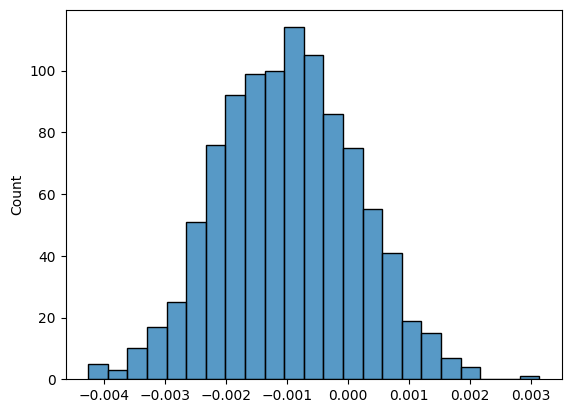

In [35]:
sns.histplot(chip_1000_random_mccs);

In [36]:
def get_z_and_p(sample, point, distribution='normal'):
    point_z = (point - np.mean(sample)) / np.std(sample)
    if distribution == 'normal':
        dist = scipy.stats.norm
    else:
        raise NotImplementedError
    point_p = dist.sf(abs(point_z)) * 2
    return point_z, point_p

performance_df['MCC_Chip_p'] = performance_df['MCC_Chip'].map(lambda mcc: get_z_and_p(chip_1000_random_mccs, mcc)[1])

performance_df

Method Dataset                                       truncated_df  \
0       ARACNe     RNA       Regulator     Gene  Rank  Score          ...   
2          CLR     RNA        Regulator     Gene   Rank   Score       ...   
4     cMonkey2     RNA        Regulator     Gene   Rank  Score        ...   
6   Elasticnet     RNA        Regulator     Gene   Rank  Score        ...   
8       GENIE3     RNA       Regulator     Gene  Rank  Score          ...   
10    iModulon     RNA       Regulator     Gene  Rank     Score       ...   
3          CLR    TFOE         index Regulator     Gene   Rank   Score...   
7   Elasticnet    TFOE         index Regulator     Gene   Rank  Score ...   
9       GENIE3    TFOE        index Regulator     Gene  Rank  Score   ...   
11         Agg     Agg        Regulator     Gene   Rank             Ed...   

              Label  MCC_Chip  MCC_Sanz  MCC_Chip_p  
0        ARACNe_RNA  1.67e-03  7.60e-03    1.84e-02  
2           CLR_RNA  5.17e-03  8.73e-03    4.52e-08  
4      cMonkey2_RNA  8.69e-03  9.65e-03    7.64e-18  
6    Elasticnet_RNA  7.83e-03  1.19e-02    4.55e-15  
8        GENIE3_RNA  5.08e-03  7.60e-03    7.09e-08  
10     iModulon_RNA  1.47e-02  2.19e-02    3.64e-44  
3          CLR_TFOE  9.63e-03  6.69e-03    3.70e-21  
7   Elasticnet_TFOE  1.80e-02  7.00e-03    9.05e-64  
9       GENIE3_TFOE  1.40e-02  1.25e-02    1.96e-40  
11          Agg_Agg  1.10e-02  8.38e-03    1.69e-26

In [37]:
reject_null, performance_df['MCC_Chip_fdr'], alphac_Sidak, alphac_Bonf = statsmodels.stats.multitest.multipletests(
    performance_df['MCC_Chip_p'], alpha=0.05, method='fdr_tsbky', is_sorted=False)

performance_df

Method Dataset                                       truncated_df  \
0       ARACNe     RNA       Regulator     Gene  Rank  Score          ...   
2          CLR     RNA        Regulator     Gene   Rank   Score       ...   
4     cMonkey2     RNA        Regulator     Gene   Rank  Score        ...   
6   Elasticnet     RNA        Regulator     Gene   Rank  Score        ...   
8       GENIE3     RNA       Regulator     Gene  Rank  Score          ...   
10    iModulon     RNA       Regulator     Gene  Rank     Score       ...   
3          CLR    TFOE         index Regulator     Gene   Rank   Score...   
7   Elasticnet    TFOE         index Regulator     Gene   Rank  Score ...   
9       GENIE3    TFOE        index Regulator     Gene  Rank  Score   ...   
11         Agg     Agg        Regulator     Gene   Rank             Ed...   

              Label  MCC_Chip  MCC_Sanz  MCC_Chip_p  MCC_Chip_fdr  
0        ARACNe_RNA  1.67e-03  7.60e-03    1.84e-02      1.94e-02  
2           CLR_RNA  5.17e-03  8.73e-03    4.52e-08      5.93e-08  
4      cMonkey2_RNA  8.69e-03  9.65e-03    7.64e-18      1.34e-17  
6    Elasticnet_RNA  7.83e-03  1.19e-02    4.55e-15      6.82e-15  
8        GENIE3_RNA  5.08e-03  7.60e-03    7.09e-08      8.27e-08  
10     iModulon_RNA  1.47e-02  2.19e-02    3.64e-44      1.91e-43  
3          CLR_TFOE  9.63e-03  6.69e-03    3.70e-21      7.76e-21  
7   Elasticnet_TFOE  1.80e-02  7.00e-03    9.05e-64      9.50e-63  
9       GENIE3_TFOE  1.40e-02  1.25e-02    1.96e-40      6.86e-40  
11          Agg_Agg  1.10e-02  8.38e-03    1.69e-26      4.43e-26

### Plot like my original AUPR plot

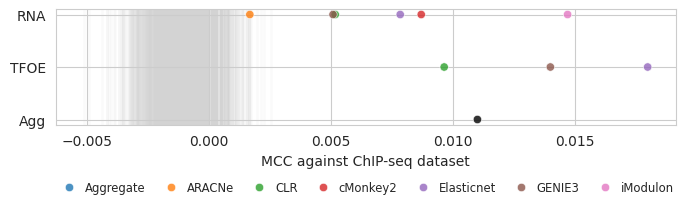

In [267]:
with sns.axes_style(style='whitegrid'):
    plt.figure(figsize=(8, 1.5), dpi=100)
    
    ax = sns.scatterplot(
        data=performance_df,
        x='MCC_Chip', y=performance_df['Dataset'],
        hue='Method',
        # style=enrichment_df[1, 'significant_adj'].rename('Significant'),
        hue_order=['Aggregate', 'ARACNe', 'CLR', 'cMonkey2', 'Elasticnet', 'GENIE3', 'iModulon'],
        alpha=0.8,
    )
    ax.xaxis.set_label_text('MCC against ChIP-seq dataset')
    ax.yaxis.set_label_text('')
    ax.legend(bbox_to_anchor=(1, 1))

    for random_mcc in chip_1000_random_mccs:
        ax.axvline(x=random_mcc, color='lightgrey', alpha=0.1, linewidth=2, zorder=-1)
        
    sns.move_legend(
        ax, 'upper center', bbox_to_anchor=(0.5, -0.4), ncols=7,
        fontsize='small', frameon=False, title=None, handletextpad=0.35, columnspacing=1.2)

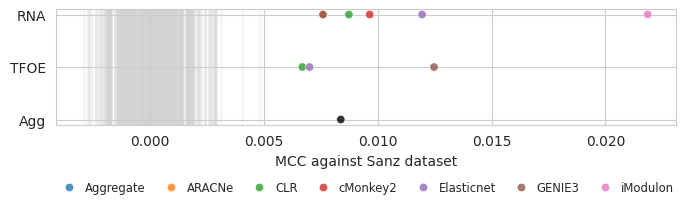

In [266]:
with sns.axes_style(style='whitegrid'):
    plt.figure(figsize=(8, 1.5), dpi=100)
    
    ax = sns.scatterplot(
        data=performance_df,
        x='MCC_Sanz', y=performance_df['Dataset'],
        hue='Method',
        # style=enrichment_df[1, 'significant_adj'].rename('Significant'),
        hue_order=['Aggregate', 'ARACNe', 'CLR', 'cMonkey2', 'Elasticnet', 'GENIE3', 'iModulon'],
        alpha=0.8,
    )
    ax.xaxis.set_label_text('MCC against Sanz dataset')
    ax.yaxis.set_label_text('')
    ax.legend(bbox_to_anchor=(1, 1))

    for random_mcc in sanz_1000_random_mccs:
        ax.axvline(x=random_mcc, color='lightgrey', alpha=0.2, linewidth=2, zorder=-1)

    sns.move_legend(
        ax, 'upper center', bbox_to_anchor=(0.5, -0.4), ncols=7,
        fontsize='small', frameon=False, title=None, handletextpad=0.35, columnspacing=1.2)

### Now plot like DREAM5 Fig 2A

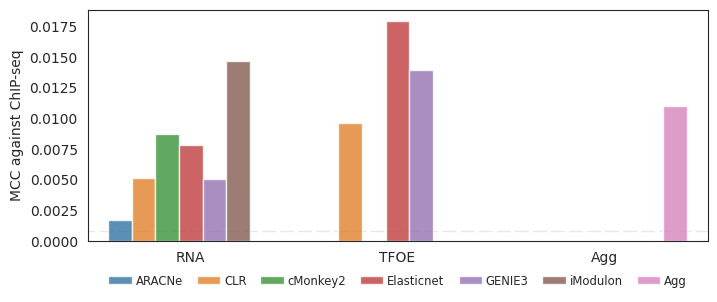

In [326]:
with sns.axes_style(style='white'):
    plt.figure(figsize=(8, 3), dpi=100)
    
    ax = sns.barplot(
        data=performance_df,
        x='Dataset', y='MCC_Chip',
        hue='Method',
        alpha=0.8,
    )
    ax.xaxis.set_label_text('')
    ax.yaxis.set_label_text('MCC against ChIP-seq')
    ax.legend(bbox_to_anchor=(1, 1))
    random_percentile95 = np.quantile(chip_1000_random_mccs, 0.95)
    ax.axhline(
        y=random_percentile95,
        color='lightgrey', alpha=0.5, linewidth=1, linestyle=(5, (10, 3)), zorder=-1)
    # ax.text(x=1.05, y=random_percentile95, s='Random MCC 95th %ile', transform=fig.transFigure)

    sns.move_legend(
        ax, 'upper center', bbox_to_anchor=(0.5, -0.1), ncols=7,
        fontsize='small', frameon=False, title=None, handletextpad=0.35, columnspacing=1.2)

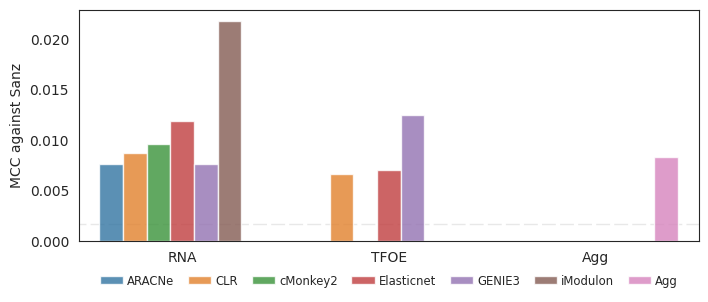

In [282]:
with sns.axes_style(style='white'):
    plt.figure(figsize=(8, 3), dpi=100)
    
    ax = sns.barplot(
        data=performance_df,
        x='Dataset', y='MCC_Sanz',
        hue='Method',
        alpha=0.8,
    )
    ax.xaxis.set_label_text('')
    ax.yaxis.set_label_text('MCC against Sanz')
    ax.legend(bbox_to_anchor=(1, 1))
    ax.axhline(
        y=np.quantile(sanz_1000_random_mccs, 0.95),
        color='lightgrey', alpha=0.5, linewidth=1, linestyle=(5, (10, 3)), zorder=-1)

    sns.move_legend(
        ax, 'upper center', bbox_to_anchor=(0.5, -0.1), ncols=7,
        fontsize='small', frameon=False, title=None, handletextpad=0.35, columnspacing=1.2)

# Overlap vs ChIP-Seq

In [284]:
def calc_venn(network_df, truth_edges):
    if 'Edge' not in network_df:
        network_edges = network_df['Regulator'].str.cat(network_df['Gene'], sep='_')
    else:
        network_edges = network_df['Edge']

    true_pos, false_pos, false_neg, true_neg = chip_validation2.confusion_matrix(
        truth_edges, network_edges, len(regulatory_space))
    
    return true_pos, f'{false_pos} | {true_pos} | {false_neg}'

In [286]:
performance_df['TP_Chip'] = performance_df['truncated_df'].map(lambda network_df: calc_venn(network_df, chipseq_df['Edge'])[0])
performance_df['venn_Chip'] = performance_df['truncated_df'].map(lambda network_df: calc_venn(network_df, chipseq_df['Edge'])[1])

performance_df

Method Dataset                                       truncated_df  \
0       ARACNe     RNA       Regulator     Gene  Rank  Score
0      Rv...   
2          CLR     RNA        Regulator     Gene   Rank   Score
0     ...   
4     cMonkey2     RNA        Regulator     Gene   Rank  Score
0      ...   
6   Elasticnet     RNA        Regulator     Gene   Rank  Score
0      ...   
8       GENIE3     RNA       Regulator     Gene  Rank  Score
0      Rv...   
10    iModulon     RNA       Regulator     Gene  Rank     Score
0     ...   
3          CLR    TFOE         index Regulator     Gene   Rank   Score...   
7   Elasticnet    TFOE         index Regulator     Gene   Rank  Score
...   
9       GENIE3    TFOE        index Regulator     Gene  Rank  Score
0 ...   
11         Agg     Agg        Regulator     Gene   Rank
0        Rv165...   

              Label  MCC_Chip  MCC_Sanz  TP_Chip           venn_Chip  
0        ARACNe_RNA  1.67e-03  7.60e-03       61    8299 | 61 | 5108  
2           CLR_RNA  5.17e-03  8.73e-03      110  11614 | 110 | 5053  
4      cMonkey2_RNA  8.69e-03  9.65e-03      200  19003 | 200 | 4954  
6    Elasticnet_RNA  7.83e-03  1.19e-02      155  14495 | 155 | 5007  
8        GENIE3_RNA  5.08e-03  7.60e-03       89    9008 | 89 | 5076  
10     iModulon_RNA  1.47e-02  2.19e-02       63    2168 | 63 | 5101  
3          CLR_TFOE  9.63e-03  6.69e-03      595  70229 | 595 | 4519  
7   Elasticnet_TFOE  1.80e-02  7.00e-03      419  31906 | 419 | 4718  
9       GENIE3_TFOE  1.40e-02  1.25e-02      116   6103 | 116 | 5051  
11          Agg_Agg  1.10e-02  8.38e-03      600  67626 | 600 | 4504

## Get expression change info from ChIP supplement

In [319]:
chipseq_pp_df = pd.read_excel(
    '../../../src/datasets/PromoterPeaks_41467_2015_BFncomms6829_MOESM48_ESM.xlsx',
    usecols='A:K', skiprows=2)
chipseq_pp_df['Edge'] = chipseq_pp_df['Regulator'].str.cat(chipseq_pp_df['gene'], sep='_')
print(chipseq_pp_df.shape)
chipseq_pp_df.head()

(7248, 12)


Regulator     gene  Peak Center (Ccenter)  Distance of peak from target  \
0   Rv0022c   Rv0029                  31964                           -93   
1   Rv0022c   Rv0030                  33245                            18   
2   Rv0022c  Rv0070c                  79205                          -109   
3   Rv0022c   Rv0309                 377896                           -35   
4   Rv0022c  Rv2077A                2334593                            -1   

  Strand of target  genome.position type of start  Expression in TFOE  \
0                +            32057   Primary.TSS                1.10   
1                +            33227   Primary.TSS                2.58   
2                -            79314   Primary.TSS                0.98   
3                +           377931   Primary.TSS                0.81   
4                -          2334594           CDS                5.27   

   p.value of expression change  Operon Differential expression in TFOE  \
0                      5.37e-11    18.0                             IND   
1                      1.26e-32    19.0                             IND   
2                      7.23e-04    47.0                             IND   
3                      6.79e-04   211.0                             IND   
4                      6.96e-48  1359.0                             IND   

              Edge  
0   Rv0022c_Rv0029  
1   Rv0022c_Rv0030  
2  Rv0022c_Rv0070c  
3   Rv0022c_Rv0309  
4  Rv0022c_Rv2077A

In [320]:
chipseq_pp_df['Direction'] = chipseq_pp_df['Differential expression in TFOE'].map({
    'IND': 'up',
    'no': 'unknown',
    'REP': 'down',
    np.nan: 'unknown',
})
chipseq_pp_df['Direction'].value_counts()

Direction
unknown    6086
down        698
up          464
Name: count, dtype: int64

In [321]:
print('All ChIP edges:          ', len(chipseq_pp_df))

chip_overlap_df = pd.DataFrame(columns=chipseq_pp_df['Direction'].unique())

chip_overlap_df.loc['Chip_in_Agg'] = chipseq_pp_df.loc[chipseq_pp_df['Edge'].isin(distenriched3_df['Edge']), 'Direction'].value_counts()
chip_overlap_df.loc['Chip_not_Agg'] = chipseq_pp_df.loc[~chipseq_pp_df['Edge'].isin(distenriched3_df['Edge']), 'Direction'].value_counts()

chip_overlap_df

All ChIP edges:           7248


up  unknown  down
Chip_in_Agg   121      500   259
Chip_not_Agg  343     5586   439

In [322]:
# significance_result = scipy.stats.fisher_exact(chip_overlap_df[['up', 'down']])
# prior_odds_ratio, p_value = significance_result.statistic, significance_result.pvalue
# This test is fine, but only includes up and down categories. I think we want to include all of them, so let's try chi-squared

result = scipy.stats.chi2_contingency(chip_overlap_df, correction=True)
# result.statistic, result.pvalue, result.dof, result.expected_freq

print(f'Probability of a random table (independent selection of categories) containing these ratios: {result.pvalue:.2g}')

fold_diff_df = chip_overlap_df / result.expected_freq
print('Fold-change observed / expected:')
fold_diff_df.map(lambda fold_val: f'{fold_val:.1f}x')

Probability of a random table (independent selection of categories) containing these ratios: 1e-126
Fold-change observed / expected:


up unknown  down
Chip_in_Agg   2.1x    0.7x  3.1x
Chip_not_Agg  0.8x    1.0x  0.7x

Looks like the ChIP edges that show up in the aggregate network are **significantly enriched for _down_-regulation**. This is not entirely expected.... since our network seems to be enriched for up-regulation -- you'd think we'd be getting more up hits than down hits. But we see the opposite.

The other interesting thing here is how **under-represented _unknown_** is. We're enriching for edges that TFOE can see a difference for.
- Does the fact that we're using TFOE as part of our heuristic for determining the direction of regulation make a difference here? ... No, I don't think so. That heuristic makes no difference on the edges present in the aggregate network. And the directionality we're looking at right now is all from the TFOE paper.
- I do think it makes sense, though. Being clearly up- or down-regulated in TFOE is likely correlated with up- or down-regulation being discernible in transcriptional data in general. A clear up- or down-regulatory relationship is what at least some of the inference methods look for. So our network will end up enriched for clear up- or down-regulatory relationships. And conversely, we will largely be blind to binding events which don't produce clear up- or down-regulation.

### Take a look at if we use our directionality matrix instead

In [313]:
master_directionality_df = pd.read_csv('master_directionality.csv', sep=',', index_col=0)
print(master_directionality_df.shape)
master_directionality_df.head()

(634610, 7)


RnaEln TfoDeg TfoEln RnaLin TfoLin         Direction  \
Rv0019c_Rv0001  False    NaN    NaN   True   True  down; maybe both   
Rv0019c_Rv0002    NaN    NaN    NaN   True   True                up   
Rv0019c_Rv0003   True    NaN    NaN   True   True                up   
Rv0019c_Rv0004    NaN    NaN    NaN   True   True                up   
Rv0019c_Rv0005    NaN    NaN    NaN  False   True              both   

                       Details  
Rv0019c_Rv0001  down/-/-/up/up  
Rv0019c_Rv0002     -/-/-/up/up  
Rv0019c_Rv0003    up/-/-/up/up  
Rv0019c_Rv0004     -/-/-/up/up  
Rv0019c_Rv0005   -/-/-/down/up

In [324]:
chipseq_pp_df['Direction2'] = chipseq_pp_df['Edge'].map(master_directionality_df['Direction'])
chipseq_pp_df.loc[chipseq_pp_df['Direction2'].isna(), 'Direction2'] = 'unknown' # complete column (remove NaN)
chipseq_pp_df.loc[chipseq_pp_df['Direction2'].eq('up; maybe both'), 'Direction2'] = 'up' # simplify
chipseq_pp_df.loc[chipseq_pp_df['Direction2'].eq('down; maybe both'), 'Direction2'] = 'down' # simplify

print('All ChIP directions (by our directionality matrix):')
display(chipseq_pp_df['Direction2'].value_counts())

print('ChIP size:', len(chipseq_pp_df))

chip_overlap_df2 = pd.DataFrame(columns=chipseq_pp_df['Direction2'].unique())

chip_overlap_df2.loc['Chip_in_Agg'] = chipseq_pp_df.loc[chipseq_pp_df['Edge'].isin(distenriched3_df['Edge']), 'Direction2'].value_counts()
chip_overlap_df2.loc['Chip_not_Agg'] = chipseq_pp_df.loc[~chipseq_pp_df['Edge'].isin(distenriched3_df['Edge']), 'Direction2'].value_counts()

print('Overlap contingency table:')
display(chip_overlap_df2)

result = scipy.stats.chi2_contingency(chip_overlap_df2, correction=True)
# result.statistic, result.pvalue, result.dof, result.expected_freq

print(f'Probability of a random table (independent selection of categories) containing these ratios: {result.pvalue:.2g}')

fold_diff_df = chip_overlap_df2 / result.expected_freq
print('Fold-change observed / expected:')
fold_diff_df.map(lambda fold_val: f'{fold_val:.1f}x')

All ChIP directions (by our directionality matrix):


Direction2
down       2617
up         2587
unknown    1792
both        252
Name: count, dtype: int64

ChIP size: 7248
Overlap contingency table:


up  unknown  both  down
Chip_in_Agg    378      106    86   310
Chip_not_Agg  2209     1686   166  2307

Probability of a random table (independent selection of categories) containing these ratios: 7.1e-42
Fold-change observed / expected:


up unknown  both  down
Chip_in_Agg   1.2x    0.5x  2.8x  1.0x
Chip_not_Agg  1.0x    1.1x  0.7x  1.0x

Now still **"purified" of _unknown_**, but **rather than _down_ being enriched, _both_ is** (_both_ not being an option in the TFOE directionality metric).

## And let's do the same for Sanz

In [317]:
sanz_solid_df['Direction'] = sanz_solid_df['Edge'].map(master_directionality_df['Direction'])
sanz_solid_df.loc[sanz_solid_df['Direction'].isna(), 'Direction'] = 'unknown' # complete column (remove NaN)
sanz_solid_df.loc[sanz_solid_df['Direction'].eq('up; maybe both'), 'Direction'] = 'up' # simplify
sanz_solid_df.loc[sanz_solid_df['Direction'].eq('down; maybe both'), 'Direction'] = 'down' # simplify

print('All Sanz directions:')
display(sanz_solid_df['Direction'].value_counts())

print('Sanz size:', len(sanz_solid_df))

sanz_overlap_df = pd.DataFrame(columns=sanz_solid_df['Direction'].unique())

sanz_overlap_df.loc['Sanz_in_Agg'] = sanz_solid_df.loc[sanz_solid_df['Edge'].isin(distenriched3_df['Edge']), 'Direction'].value_counts()
sanz_overlap_df.loc['Sanz_not_Agg'] = sanz_solid_df.loc[~sanz_solid_df['Edge'].isin(distenriched3_df['Edge']), 'Direction'].value_counts()

print('Overlap contingency table:')
display(sanz_overlap_df)

result = scipy.stats.chi2_contingency(sanz_overlap_df, correction=True)
# result.statistic, result.pvalue, result.dof, result.expected_freq

print(f'Probability of a random table (independent selection of categories) containing these ratios: {result.pvalue:.2g}')

fold_diff_df = sanz_overlap_df / result.expected_freq
print('Fold-change observed / expected:')
fold_diff_df.map(lambda fold_val: f'{fold_val:.1f}x')

All Sanz directions:


Direction
up         151
down       140
unknown    138
both        20
Name: count, dtype: int64

Sanz size: 449
Overlap contingency table:


down   up  unknown  both
Sanz_in_Agg     20   35       11    14
Sanz_not_Agg   120  116      127     6

Probability of a random table (independent selection of categories) containing these ratios: 6.3e-11
Fold-change observed / expected:


down    up unknown  both
Sanz_in_Agg   0.8x  1.3x    0.4x  3.9x
Sanz_not_Agg  1.0x  0.9x    1.1x  0.4x

So here we seem to be **"purified" of _unknown_ direction** relationships in the aggregate network, and **very enriched for _both_ direction** relationships. Similar to what we see in the ChIP/our-directionality analysis.

# Deconvolute network

In [402]:
def maybe_prune(node, graph, network_df, removed=[], verbosity=0):
    node_regulators = graph.predecessors(node)

    for regulator in node_regulators:
        indirect_candidates = [tf for tf in graph.predecessors(regulator) if tf in node_regulators]
        if len(indirect_candidates) > 0:
            regulator_node_edge_rank = network_df.loc[
                network_df['Regulator'].eq(regulator) & network_df['Gene'].eq(node),
                'Rank'
            ].iloc[0]
        
        for candidate in indirect_candidates:
            candidate_node_edge_rank = network_df.loc[
                network_df['Regulator'].eq(candidate) & network_df['Gene'].eq(node),
                'Rank'
            ].iloc[0]
            if candidate_node_edge_rank < regulator_node_edge_rank:
                graph.remove_edge(candidate, node)
                removed.append((candidate, node))
                if verbosity >= 2:
                    print(f'Removing edge {candidate} -> {node} due to stronger connection {regulator} -> {node}')

def deconvolute(graph, network_df, nodes=None, removed=[], completed=set(), verbosity=0):
    if nodes == None:
        nodes = [node for node in graph.nodes() if graph.out_degree(node) == 0] # start with leaf nodes
    else:
        nodes = [node for node in nodes if node not in completed] # otherwise make sure we only do each node once, or we'll recurse forever
    
    for node in nodes: # breadth-first -- do all of this level, then dive
        maybe_prune(node, graph, network_df, removed=removed, verbosity=verbosity)
        completed.add(node)

    for node in nodes: # dive (means this is not exactly breadth-first, but I think that's ok)
        deconvolute(graph, network_df, nodes=graph.predecessors(node), removed=removed, completed=completed, verbosity=verbosity)

    return removed

In [403]:
distenriched3_g2 = distenriched3_g.copy()

print(f'Original network has {len(distenriched3_g2.nodes)} nodes and {len(distenriched3_g2.edges)} edges')

start = time.time()
removed = deconvolute(distenriched3_g2, distenriched3_df)
print(f'(Deconvolution completed in {time.time() - start:.1f} seconds)')

print(f'Deconvoluted network has {len(distenriched3_g2.nodes)} nodes and {len(distenriched3_g2.edges)} edges')

print(f'Removed {len(removed)} edges:', ', '.join(f'{tf}_{target}' for tf, target in removed[:5]) + '...')

Original network has 4027 nodes and 68226 edges
(Deconvolution completed in 10.6 seconds)
Deconvoluted network has 4027 nodes and 67649 edges
Removed 577 edges: Rv3133c_Rv3132c, Rv3414c_Rv3413c, Rv0823c_Rv1178, Rv3133c_Rv2628, Rv3414c_Rv2721c...


In [407]:
distenriched3_decon_df = distenriched3_df[~distenriched3_df['Edge'].isin([f'{tf}_{target}' for tf, target in removed])].reset_index(drop=True)
distenriched3_decon_df['Rank'] = distenriched3_decon_df.index.to_series() + 1
print(distenriched3_decon_df.shape)
distenriched3_decon_df.head()

(67649, 4)


Regulator     Gene  Rank             Edge
0    Rv1657   Rv1659     1    Rv1657_Rv1659
1    Rv1657   Rv1658     2    Rv1657_Rv1658
2   Rv3249c  Rv3250c     3  Rv3249c_Rv3250c
3    Rv0081   Rv0085     4    Rv0081_Rv0085
4   Rv3417c   Rv0440     5   Rv3417c_Rv0440

## Reattempt degree distributions and small-world-ness

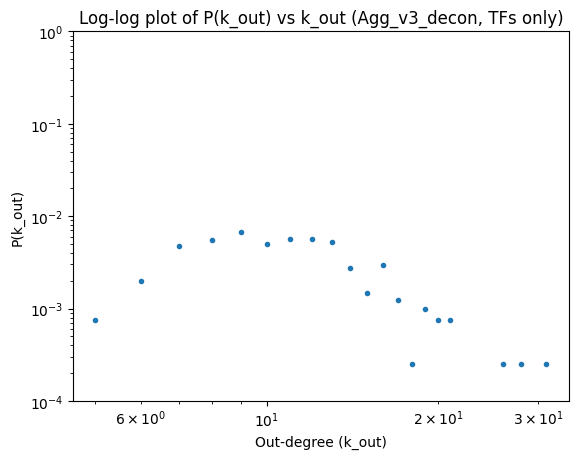

In [394]:
# Calculate degree sequences and frequency
distenriched3_degrees2 = np.array([distenriched3_g2.out_degree(n) for n in distenriched3_g2.nodes()])
# distenriched3_degree_counts = np.bincount(distenriched3_degrees2)
distenriched3_degree_counts2, bin_edges = np.histogram(distenriched3_degrees2, bins=32)
distenriched3_degrees2 = np.arange(len(distenriched3_degree_counts2))

mask = distenriched3_degree_counts2 > 0
plt.loglog(distenriched3_degrees2[mask], distenriched3_degree_counts2[mask] / len(distenriched3_g2.nodes), color='tab:blue', linestyle='', marker='.')
plt.xlabel('Out-degree (k_out)')
plt.ylabel('P(k_out)')
plt.title('Log-log plot of P(k_out) vs k_out (Agg_v3_decon, TFs only)')
plt.ylim(1e-4, 1);  # Assuming you want to start at 1e-4 and end at 1 for P(k)
# plt.xlim(1, 100)

In [400]:
lp1 = average_shortest_path_length(distenriched3_g2)
print(lp1)
lp2 = average_shortest_path_length2(distenriched3_g2)
print(lp2)

0.11960770018470702
Returning average shortest path length for 214 subgraph nodes (out of 4027 total in supplied graph)
2.2202185073055154


## Try GO again, just in case this ~1% reduction makes a difference

In [418]:
distenriched3_decon_directed_df = distenriched3_decon_df.copy()

if 'Edge' not in distenriched3_directed_df.columns:
    distenriched3_directed_df['Edge'] = distenriched3_directed_df['Regulator'].str.cat(distenriched3_directed_df['Gene'], sep='_')

distenriched3_decon_directed_df['Direction'] = distenriched3_decon_directed_df['Edge'].map(
    distenriched3_directed_df.set_index('Edge')['Direction'])
print(distenriched3_decon_directed_df.shape)
distenriched3_decon_directed_df.head()

(67649, 5)


Regulator     Gene  Rank             Edge Direction
0    Rv1657   Rv1659     1    Rv1657_Rv1659        up
1    Rv1657   Rv1658     2    Rv1657_Rv1658        up
2   Rv3249c  Rv3250c     3  Rv3249c_Rv3250c        up
3    Rv0081   Rv0085     4    Rv0081_Rv0085      both
4   Rv3417c   Rv0440     5   Rv3417c_Rv0440        up

In [420]:
decon_go_dfs = []

directions = {
    'up': ['up', 'up; maybe both'],
    'down': ['down', 'down; maybe both'],
    'both': ['both', 'up; maybe both', 'down; maybe both'],
}

for regulator in regulator_analysis_df.index:
    for major_direction, minor_directions in directions.items():
        gene_loci = distenriched3_decon_directed_df.loc[
            distenriched3_decon_directed_df['Regulator'].eq(regulator) &
                distenriched3_decon_directed_df['Direction'].isin(minor_directions),
            'Gene'
        ]
        if len(gene_loci) == 0:
            continue
        go_df = mtb_gene_ontology(gene_loci=gene_loci, name=f'{regulator}-{major_direction}')
        go_df.drop(index=go_df[go_df['p_uncorrected'].ge(0.05)].index, inplace=True)
        go_df.insert(0, 'Regulator', regulator)
        go_df.insert(1, 'Direction', major_direction)
        decon_go_dfs.append(go_df)

decon_go_df = pd.concat(decon_go_dfs)
print(decon_go_df.shape)
decon_go_df.head()

Performing gene ontology on 199 genes (out of 3984 total Mtb genes)
3364 IDs in loaded association branch, biological_process

Load  Ontology Enrichment Analysis ...
Propagating term counts up: is_a
 84%  3,350 of  3,984 population items found in association

Runing  Ontology Analysis: Rv0019c-up study set of 199 IDs.
 89%    177 of    199 study items found in association
100%    199 of    199 study items found in population(3984)
Calculating 3,925 uncorrected p-values using fisher_scipy_stats
   3,925 terms are associated with  3,350 of  3,984 population items
   1,051 terms are associated with    177 of    199 study items
  METHOD fdr_tsbky:
      21 GO terms found significant (< 0.05=alpha) ( 20 enriched +   1 purified): statsmodels fdr_tsbky
     140 study items associated with significant GO IDs (enriched)
       8 study items associated with significant GO IDs (purified)
Performing gene ontology on 106 genes (out of 3984 total Mtb genes)
3364 IDs in loaded association branch, bio

Regulator Direction          GO  NS enrichment  \
0   Rv0019c        up  GO:1901566  BP          e   
1   Rv0019c        up  GO:1901564  BP          e   
2   Rv0019c        up  GO:0009058  BP          e   
3   Rv0019c        up  GO:0008152  BP          e   
4   Rv0019c        up  GO:0044237  BP          e   

                                           name ratio_in_study  ratio_in_pop  \
0  organonitrogen compound biosynthetic process      (52, 199)   (426, 3984)   
1     organonitrogen compound metabolic process      (67, 199)   (649, 3984)   
2                          biosynthetic process      (70, 199)   (778, 3984)   
3                             metabolic process     (110, 199)  (1492, 3984)   
4                    cellular metabolic process      (76, 199)   (978, 3984)   

   p_uncorrected  depth  ...  pop_n  \
0       3.13e-10      3  ...   3984   
1       6.52e-10      2  ...   3984   
2       1.06e-07      2  ...   3984   
3       1.71e-07      1  ...   3984   
4       1.36e-05      2  ...   3984   

                                              goterm          id     item_id  \
0  GO:1901566\tlevel-03\tdepth-03\torganonitrogen...  GO:1901566  GO:1901566   
1  GO:1901564\tlevel-02\tdepth-02\torganonitrogen...  GO:1901564  GO:1901564   
2  GO:0009058\tlevel-02\tdepth-02\tbiosynthetic p...  GO:0009058  GO:0009058   
3  GO:0008152\tlevel-01\tdepth-01\tmetabolic proc...  GO:0008152  GO:0008152   
4  GO:0044237\tlevel-02\tdepth-02\tcellular metab...  GO:0044237  GO:0044237   

            namespace                                            parents  \
0  biological_process  {GO:0009058\tlevel-02\tdepth-02\tbiosynthetic ...   
1  biological_process  {GO:0008152\tlevel-01\tdepth-01\tmetabolic pro...   
2  biological_process  {GO:0008152\tlevel-01\tdepth-01\tmetabolic pro...   
3  biological_process  {GO:0008150\tlevel-00\tdepth-00\tbiological_pr...   
4  biological_process  {GO:0008152\tlevel-01\tdepth-01\tmetabolic pro...   

                                            children  level is_obsolete  \
0  {GO:0042158\tlevel-04\tdepth-05\tlipoprotein b...      3       False   
1  {GO:0009820\tlevel-03\tdepth-03\talkaloid meta...      2       False   
2  {GO:1903409\tlevel-03\tdepth-04\treactive oxyg...      2       False   
3  {GO:1901275\tlevel-02\tdepth-02\ttartrate meta...      1       False   
4  {GO:0043094\tlevel-03\tdepth-03\tcellular meta...      2       False   

                    alt_ids  
0                        {}  
1                        {}  
2  {GO:0044711, GO:0044274}  
3  {GO:0044710, GO:0044236}  
4                        {}  

[5 rows x 27 columns]

In [421]:
sgnfcnt_decon_go_df = decon_go_df.loc[decon_go_df['p_fdr_tsbky'].lt(0.05), 'Regulator':'alt_ids'].reset_index(drop=True)
print(sgnfcnt_decon_go_df.shape)
sgnfcnt_decon_go_df.head()

(3569, 27)


Regulator Direction          GO  NS enrichment  \
0   Rv0019c        up  GO:1901566  BP          e   
1   Rv0019c        up  GO:1901564  BP          e   
2   Rv0019c        up  GO:0009058  BP          e   
3   Rv0019c        up  GO:0008152  BP          e   
4   Rv0019c        up  GO:0044237  BP          e   

                                           name ratio_in_study  ratio_in_pop  \
0  organonitrogen compound biosynthetic process      (52, 199)   (426, 3984)   
1     organonitrogen compound metabolic process      (67, 199)   (649, 3984)   
2                          biosynthetic process      (70, 199)   (778, 3984)   
3                             metabolic process     (110, 199)  (1492, 3984)   
4                    cellular metabolic process      (76, 199)   (978, 3984)   

   p_uncorrected  depth  ...  pop_n  \
0       3.13e-10      3  ...   3984   
1       6.52e-10      2  ...   3984   
2       1.06e-07      2  ...   3984   
3       1.71e-07      1  ...   3984   
4       1.36e-05      2  ...   3984   

                                              goterm          id     item_id  \
0  GO:1901566\tlevel-03\tdepth-03\torganonitrogen...  GO:1901566  GO:1901566   
1  GO:1901564\tlevel-02\tdepth-02\torganonitrogen...  GO:1901564  GO:1901564   
2  GO:0009058\tlevel-02\tdepth-02\tbiosynthetic p...  GO:0009058  GO:0009058   
3  GO:0008152\tlevel-01\tdepth-01\tmetabolic proc...  GO:0008152  GO:0008152   
4  GO:0044237\tlevel-02\tdepth-02\tcellular metab...  GO:0044237  GO:0044237   

            namespace                                            parents  \
0  biological_process  {GO:0009058\tlevel-02\tdepth-02\tbiosynthetic ...   
1  biological_process  {GO:0008152\tlevel-01\tdepth-01\tmetabolic pro...   
2  biological_process  {GO:0008152\tlevel-01\tdepth-01\tmetabolic pro...   
3  biological_process  {GO:0008150\tlevel-00\tdepth-00\tbiological_pr...   
4  biological_process  {GO:0008152\tlevel-01\tdepth-01\tmetabolic pro...   

                                            children  level is_obsolete  \
0  {GO:0042158\tlevel-04\tdepth-05\tlipoprotein b...      3       False   
1  {GO:0009820\tlevel-03\tdepth-03\talkaloid meta...      2       False   
2  {GO:1903409\tlevel-03\tdepth-04\treactive oxyg...      2       False   
3  {GO:1901275\tlevel-02\tdepth-02\ttartrate meta...      1       False   
4  {GO:0043094\tlevel-03\tdepth-03\tcellular meta...      2       False   

                    alt_ids  
0                        {}  
1                        {}  
2  {GO:0044711, GO:0044274}  
3  {GO:0044710, GO:0044236}  
4                        {}  

[5 rows x 27 columns]

In [422]:
sgnfcnt_decon_go_df['Regulator'].value_counts()

Regulator
Rv2610c    269
Rv2215     210
Rv2258c    194
Rv0339c    192
Rv2703     125
          ... 
Rv1027c      1
Rv0880       1
Rv3328c      1
Rv0324       1
Rv2621c      1
Name: count, Length: 133, dtype: int64

## Measure MCC again

In [425]:
performance_df.columns

Index(['Method', 'Dataset', 'truncated_df', 'Label', 'MCC_Chip', 'MCC_Sanz',
       'TP_Chip', 'venn_Chip'],
      dtype='object')

In [427]:
performance_df2 = performance_df.copy()

performance_df2.loc[max(performance_df2.index) + 1] = (
    'Dcv', 'Agg', distenriched3_decon_df, 'Dcv_Agg',
    calc_mcc(distenriched3_decon_df, chipseq_df['Edge']),
    calc_mcc(distenriched3_decon_df, sanz_solid_df['Edge']),
    calc_venn(distenriched3_decon_df, chipseq_df['Edge'])[0],
    calc_venn(distenriched3_decon_df, chipseq_df['Edge'])[1],
)

performance_df2

Method Dataset                                       truncated_df  \
0       ARACNe     RNA       Regulator     Gene  Rank  Score
0      Rv...   
2          CLR     RNA        Regulator     Gene   Rank   Score
0     ...   
4     cMonkey2     RNA        Regulator     Gene   Rank  Score
0      ...   
6   Elasticnet     RNA        Regulator     Gene   Rank  Score
0      ...   
8       GENIE3     RNA       Regulator     Gene  Rank  Score
0      Rv...   
10    iModulon     RNA       Regulator     Gene  Rank     Score
0     ...   
3          CLR    TFOE         index Regulator     Gene   Rank   Score...   
7   Elasticnet    TFOE         index Regulator     Gene   Rank  Score
...   
9       GENIE3    TFOE        index Regulator     Gene  Rank  Score
0 ...   
11         Agg     Agg        Regulator     Gene   Rank
0        Rv165...   
12         Dcv     Agg        Regulator     Gene   Rank             Ed...   

              Label  MCC_Chip  MCC_Sanz  TP_Chip           venn_Chip  
0        ARACNe_RNA  1.67e-03  7.60e-03       61    8299 | 61 | 5108  
2           CLR_RNA  5.17e-03  8.73e-03      110  11614 | 110 | 5053  
4      cMonkey2_RNA  8.69e-03  9.65e-03      200  19003 | 200 | 4954  
6    Elasticnet_RNA  7.83e-03  1.19e-02      155  14495 | 155 | 5007  
8        GENIE3_RNA  5.08e-03  7.60e-03       89    9008 | 89 | 5076  
10     iModulon_RNA  1.47e-02  2.19e-02       63    2168 | 63 | 5101  
3          CLR_TFOE  9.63e-03  6.69e-03      595  70229 | 595 | 4519  
7   Elasticnet_TFOE  1.80e-02  7.00e-03      419  31906 | 419 | 4718  
9       GENIE3_TFOE  1.40e-02  1.25e-02      116   6103 | 116 | 5051  
11          Agg_Agg  1.10e-02  8.38e-03      600  67626 | 600 | 4504  
12          Dcv_Agg  1.06e-02  8.09e-03      589  67060 | 589 | 4518

# What distribution does overlap with Sanz follow?

## Hypergeometric?

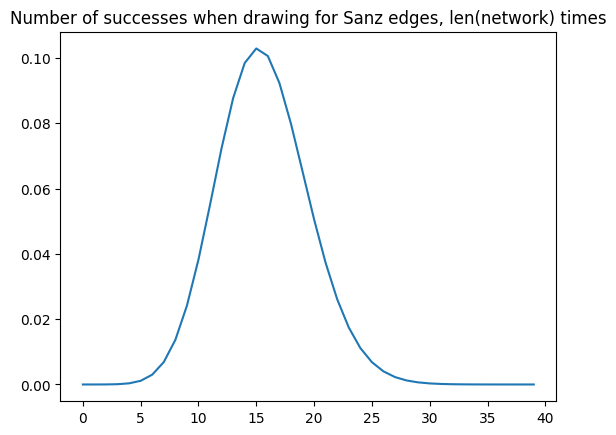

In [443]:
hypergeom_rand_var = scipy.stats.hypergeom(M=len(regulatory_space), n=len(sanz_solid_df), N=len(constituent_networks_df.at[0, 'network_df']))

# x = np.arange(start=0, stop=len(sanz_solid_df), step=1)
x = np.arange(start=0, stop=40, step=1)
y = hypergeom_rand_var.pmf(x)

ax = sns.lineplot(
    x=x,
    y=y,
)
ax.set_title('Number of successes when drawing for Sanz edges, len(network) times');

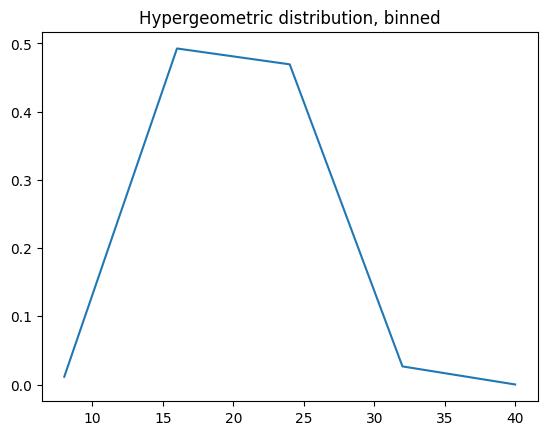

In [446]:
hypergeom_rand_var = scipy.stats.hypergeom(M=len(regulatory_space), n=len(sanz_solid_df), N=len(constituent_networks_df.at[0, 'network_df']))

stop = 40
# x = np.arange(start=0, stop=len(sanz_solid_df), step=1)
x = np.arange(start=0, stop=stop, step=1)
y = hypergeom_rand_var.pmf(x)

bins=5
y_binned = []
idxs = list(range(stop//bins, stop+1, stop//bins))
prev = 0
for idx in idxs:
    y_binned.append(y[prev:idx].sum())
    prev = idx

ax = sns.lineplot(
    x=idxs,
    y=y_binned,
)
ax.set_title('Hypergeometric distribution, binned');

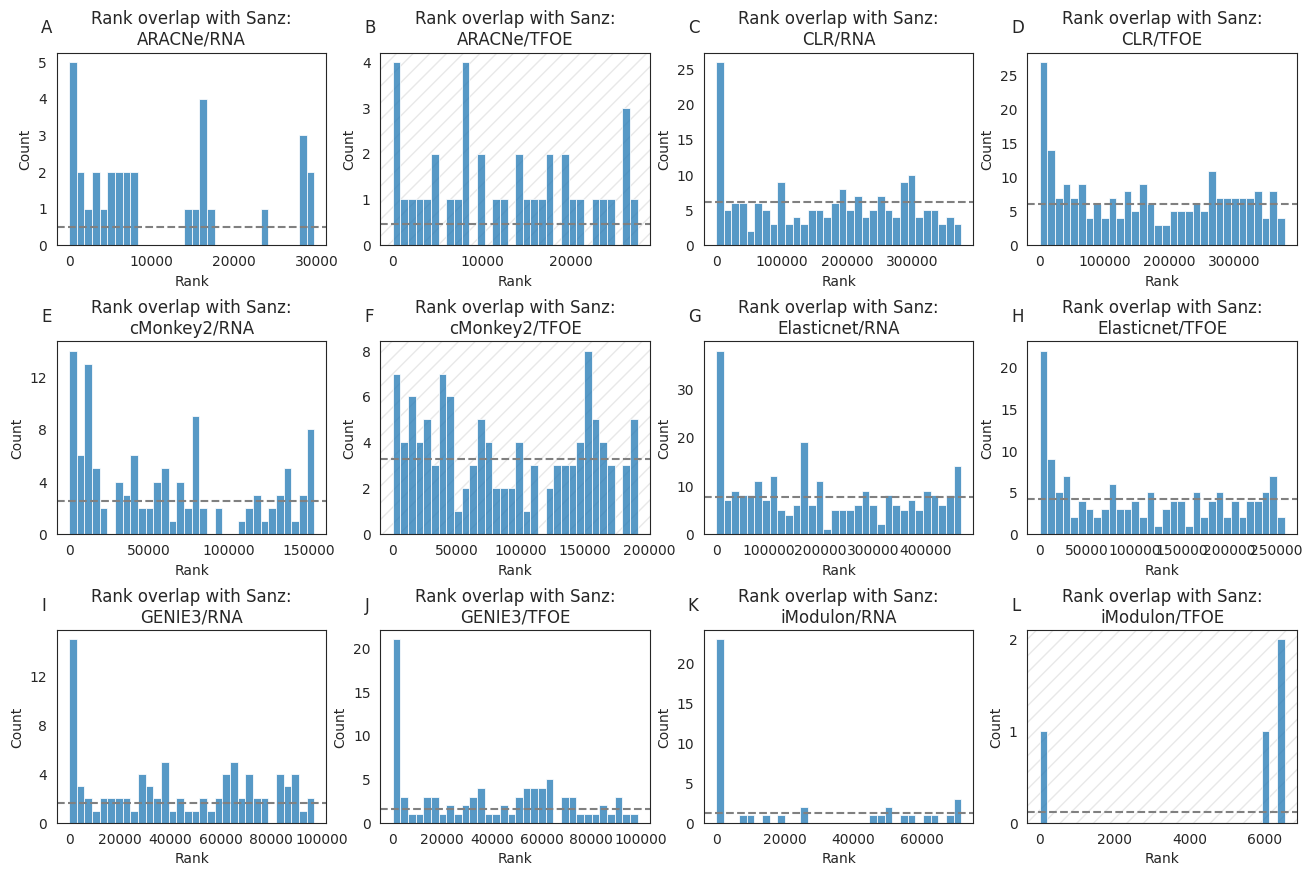

In [447]:
with sns.axes_style(style='white'):
    fig = plt.figure(figsize=(16, 10))
    axs = fig.subplots(nrows=3, ncols=4, sharex=False, sharey=False, squeeze=True, gridspec_kw={'hspace': 0.5}).flatten()
    
    panel_labels = 'ABCDEFGHIJKL'
    
    # tweaks for specific panels
    
    hatch_backgrounds = [False for ax in axs]
    hatch_backgrounds[1] = True
    hatch_backgrounds[5] = True
    hatch_backgrounds[11] = True
    
    x_ticks = [[] for ax in axs] # empty = use default
    x_ticks[4] = [0, 50_000, 100_000, 150_000]
    
    y_ticks = [[] for ax in axs] # empty = use default
    y_ticks[4] = [0, 4, 8, 12]
    y_ticks[8] = [0, 4, 8, 12]
    y_ticks[11] = [0, 1, 2]
    
    # plot
    
    for i in range(len(axs)):
        df_i = constituent_networks_df.at[i, 'network_df']
        df_i['Edge'] = df_i['Regulator'].str.cat(df_i['Gene'], sep='_')
        df_i2 = df_i[df_i['Edge'].isin(sanz_solid_df['Edge'])]
    
        bin_count = 32
        bin_size = len(df_i) / bin_count
        noise_per_bin = len(sanz_solid_df) * bin_size / len(regulatory_space)

        ax = sns.histplot(df_i2['Rank'], bins=bin_count, ax=axs[i])
        ax.axhline(noise_per_bin, color='grey', linestyle='--')
        ax.set_title((
            f"Rank overlap with Sanz:\n"
            f"{constituent_networks_df.at[i, 'Method']}/{constituent_networks_df.at[i, 'Dataset']}"
        ))
        if hatch_backgrounds[i]:
            ymax = ax.get_ylim()[1]
            ax.fill_between(
                ax.get_xlim(), (ymax, ymax),
                hatch='//', color='#E8E8E8', facecolor=sns.axes_style()['axes.facecolor'],
                transform=ax.transAxes, zorder=0)
        if len(x_ticks[i]) > 0:
            ax.set_xticks(x_ticks[i])
        if len(y_ticks[i]) > 0:
            ax.set_yticks(y_ticks[i])
        ax.text(
            x=ax.get_position().xmin - 0.01,
            y=ax.get_position().ymax + 0.02,
            s=panel_labels[i],
            size='large', weight='roman',
            transform=fig.transFigure)

Sanz: set of true positives
- from this, can calculate false negative rate
- we also have number of edges that would have been found randomly (based on the size of the network), and the number of Sanz edges we actually did find
  - does this ratio give us a false positive rate?

set of true negatives
- from this, calculate false positive rate?

In [476]:
for idx in performance_df.index:
    df_i = performance_df.at[idx, 'truncated_df']
    df_i2 = df_i[df_i['Regulator'].str.cat(df_i['Gene'], sep='_').isin(sanz_solid_df['Edge'])]

    hypergeom_rand_var = scipy.stats.hypergeom(M=len(regulatory_space), n=len(sanz_solid_df), N=len(df_i))
    expected_overlap = hypergeom_rand_var.mean()
    lower_ci = hypergeom_rand_var.ppf(0.05)
    upper_ci = hypergeom_rand_var.ppf(0.95)
    
    print(
        f'{performance_df.at[idx, 'Method']:>10s}/{performance_df.at[idx, 'Dataset']:<4s},',
        f'length of network: {len(df_i):>5d},',
        f'expected overlap: {expected_overlap:.2f},',
        f'observed overlap: {len(df_i2):>2d},',
        f'presumed FDR: {expected_overlap/len(df_i2):.0%}',
        f'({lower_ci/len(df_i2):.0%}, {upper_ci/len(df_i2):.0%})',
    )
    performance_df.at[idx, 'length'] = len(df_i)
    performance_df.at[idx, 'naive_FDR'] = expected_overlap/len(df_i2)
    performance_df.at[idx, 'naive_FDR_ci_hi'] = upper_ci/len(df_i2)
    performance_df.at[idx, 'naive_FDR_ci_lo'] = lower_ci/len(df_i2)

    ARACNe/RNA , length of network:  8360, expected overlap: 4.35, observed overlap: 19, presumed FDR: 23% (5%, 42%)
       CLR/RNA , length of network: 11724, expected overlap: 6.10, observed overlap: 26, presumed FDR: 23% (8%, 38%)
  cMonkey2/RNA , length of network: 19203, expected overlap: 10.00, observed overlap: 38, presumed FDR: 26% (13%, 39%)
Elasticnet/RNA , length of network: 14650, expected overlap: 7.63, observed overlap: 38, presumed FDR: 20% (8%, 32%)
    GENIE3/RNA , length of network:  9097, expected overlap: 4.73, observed overlap: 20, presumed FDR: 24% (10%, 45%)
  iModulon/RNA , length of network:  2231, expected overlap: 1.16, observed overlap: 23, presumed FDR: 5% (0%, 13%)
       CLR/TFOE, length of network: 70824, expected overlap: 36.86, observed overlap: 73, presumed FDR: 50% (38%, 64%)
Elasticnet/TFOE, length of network: 32325, expected overlap: 16.83, observed overlap: 43, presumed FDR: 39% (23%, 56%)
    GENIE3/TFOE, length of network:  6219, expected overla

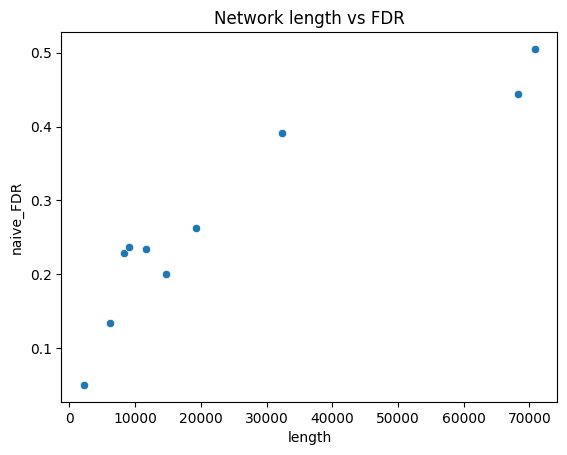

In [479]:
ax = sns.scatterplot(
    data=performance_df,
    x='length',
    y='naive_FDR'
)
ax.set_title('Network length vs FDR');

In [487]:
import sklearn.linear_model as skllm
from matplotlib.patches import Patch

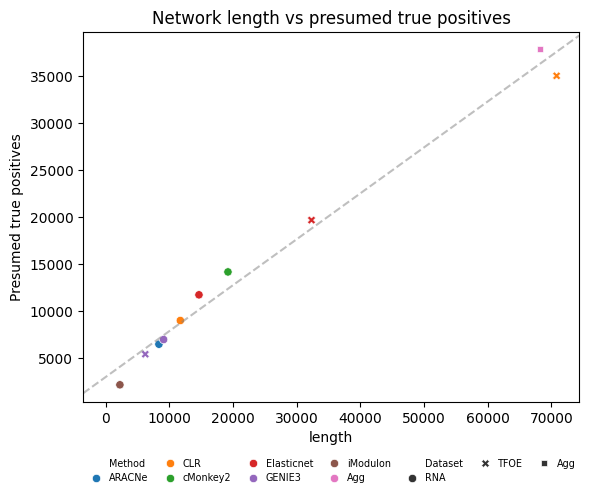

In [492]:
ax = sns.scatterplot(
    data=performance_df,
    x=performance_df['length'],
    y=performance_df['length'] * (1 - performance_df['naive_FDR']),
    hue=performance_df['Method'],
    style=performance_df['Dataset'],
)
ax.set_ylabel('Presumed true positives')

model = skllm.LinearRegression().fit(
    X=performance_df['length'].to_numpy().reshape((-1, 1)),
    y=(performance_df['length'] * (1 - performance_df['naive_FDR'])).to_numpy()
)

ax.axline((0, model.intercept_), slope=model.coef_[0], alpha=0.5, color='grey', linestyle='--')

sns.move_legend(
    ax, 'upper center', bbox_to_anchor=(0.5, -0.13), ncols=7,
    fontsize='x-small', frameon=False, title=None, handletextpad=0.35, columnspacing=1.2)
ax.set_title('Network length vs presumed true positives');

# Original Sizes

In [12]:
for idx, row in constituent_networks_df.iterrows():
    print(f"{row['Method']:>10s}/{row['Dataset']:4s}: length={len(row['network_df']): 8,d}")

    ARACNe/RNA : length=  30,005
    ARACNe/TFOE: length=  28,215
       CLR/RNA : length= 375,711
       CLR/TFOE: length= 376,144
  cMonkey2/RNA : length= 154,146
  cMonkey2/TFOE: length= 201,211
Elasticnet/RNA : length= 477,197
Elasticnet/TFOE: length= 259,466
    GENIE3/RNA : length=  99,883
    GENIE3/TFOE: length=  99,223
  iModulon/RNA : length=  76,778
  iModulon/TFOE: length=   7,159


In [19]:
all_edges = set()

for idx in constituent_networks_df.index:
    network_df = constituent_networks_df.at[idx, 'network_df']
    network_df['Edge'] = network_df['Regulator'].str.cat(network_df['Gene'], sep='_')
    all_edges |= set(network_df['Edge'].to_list())

len(all_edges)

779213

In [499]:
len(all_edges) / (len(regulatory_space) - len(regulators_df))

0.9035191669951995

In [21]:
all_targets = set()

for idx in constituent_networks_df.index:
    network_df = constituent_networks_df.at[idx, 'network_df']
    all_targets |= set(network_df['Gene'].to_list())

len(all_targets)

4029

In [22]:
all_tfs = set()

for idx in constituent_networks_df.index:
    network_df = constituent_networks_df.at[idx, 'network_df']
    all_tfs |= set(network_df['Regulator'].to_list())

len(all_tfs)

214

In [24]:
len(distenriched3_df['Regulator'].unique())

214

# Network visualization

In [38]:
distenriched3_g

In [41]:
interesting_tfs = {
    'Rv2258c': 'Rv2258c',
    'Rv1674c': 'Rv1674c',
    'Rv3197A': 'whiB7',
    'Rv3574': 'kstR',
    'Rv1725c': 'Rv1725c',
    'Rv0023': 'Rv0023',
    'Rv0586': 'mce2R',
}

In [42]:
regulons = {}

for tf in interesting_tfs:
    regulons[tf] = distenriched3_directed_df.loc[distenriched3_directed_df['Regulator'].eq(tf), 'Gene']

regulons

{'Rv2258c': 126      Rv2257c
 234       Rv1484
 316       Rv1901
 344       Rv0562
 363      Rv0429c
           ...   
 65008    Rv2051c
 65111    Rv3647c
 65173    Rv1837c
 65217     Rv1020
 65288    Rv3220c
 Name: Gene, Length: 857, dtype: object,
 'Rv1674c': 1468     Rv1672c
 1641      Rv1995
 1764      Rv0331
 1904     Rv1048c
 2735      Rv0793
           ...   
 66802     Rv1790
 67152    Rv3379c
 67518     Rv1288
 68111    Rv1040c
 68204    Rv2323c
 Name: Gene, Length: 196, dtype: object,
 'Rv3197A': 233      Rv2416c
 239      Rv1258c
 260       Rv1988
 476      Rv2725c
 689      Rv2415c
           ...   
 67760     Rv0970
 68032    Rv0441c
 68112     Rv3861
 68131     Rv2209
 68156    Rv3802c
 Name: Gene, Length: 351, dtype: object,
 'Rv3574': 310      Rv1894c
 430       Rv3527
 478      Rv3567c
 554      Rv3536c
 717       Rv3571
           ...   
 67714    Rv3161c
 67737    Rv1217c
 67817     Rv0245
 67908     Rv0675
 68186    Rv1218c
 Name: Gene, Length: 280, dtype: object,
 

In [53]:
all_targets = set()

for tf in interesting_tfs:
    all_targets |= set(regulons[tf].to_list())

targets_df = pd.DataFrame(index=sorted(all_targets))

targets_df['Sum'] = 0

for tf in interesting_tfs:
    targets_df.loc[regulons[tf].to_list(), tf] = True
    targets_df.loc[regulons[tf].to_list(), 'Sum'] += 1

targets_df

Sum Rv2258c Rv1674c Rv3197A Rv3574 Rv1725c Rv0023 Rv0586
Rv0001     1     NaN     NaN     NaN    NaN     NaN   True    NaN
Rv0002     1    True     NaN     NaN    NaN     NaN    NaN    NaN
Rv0003     1    True     NaN     NaN    NaN     NaN    NaN    NaN
Rv0004     1    True     NaN     NaN    NaN     NaN    NaN    NaN
Rv0005     1     NaN     NaN     NaN    NaN     NaN    NaN   True
...      ...     ...     ...     ...    ...     ...    ...    ...
Rv3920c    1    True     NaN     NaN    NaN     NaN    NaN    NaN
Rv3921c    1    True     NaN     NaN    NaN     NaN    NaN    NaN
Rv3922c    1    True     NaN     NaN    NaN     NaN    NaN    NaN
Rv3923c    1    True     NaN     NaN    NaN     NaN    NaN    NaN
Rv3924c    1    True     NaN     NaN    NaN     NaN    NaN    NaN

[1992 rows x 8 columns]

72


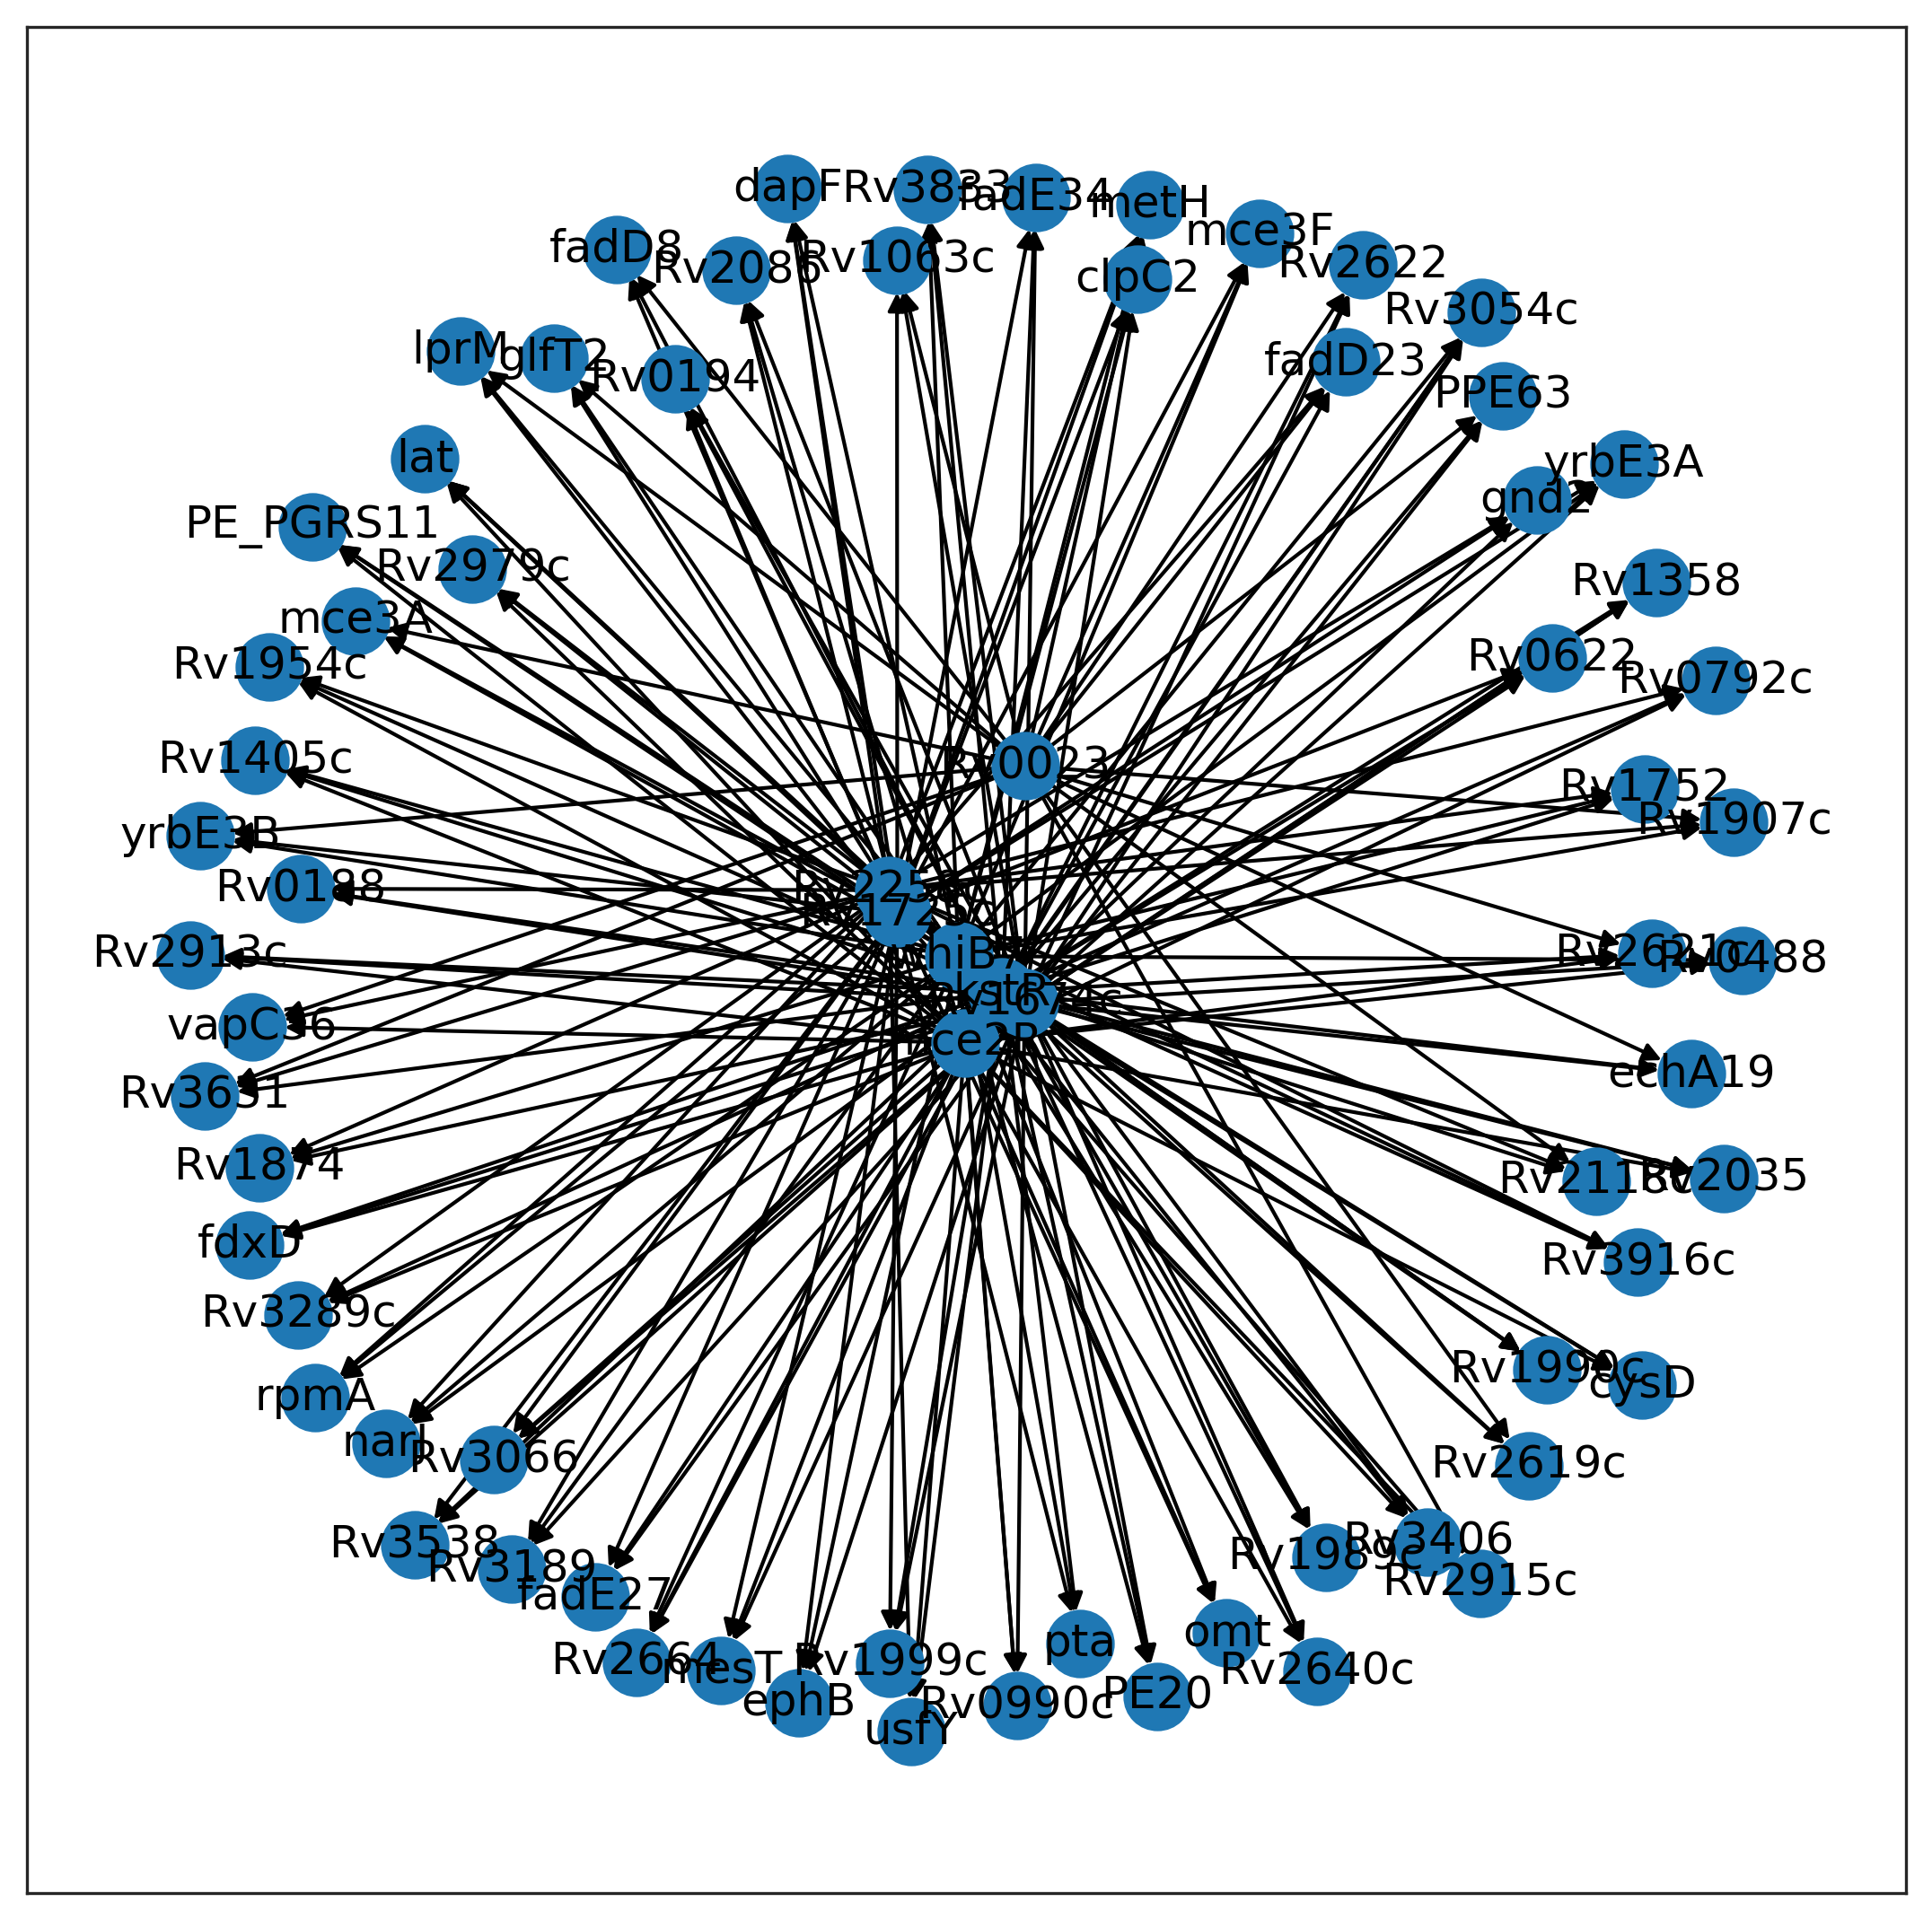

In [89]:
targets = set(targets_df[targets_df['Sum'].gt(2)].index)
regulators = set(interesting_tfs)
print(len(targets | regulators))

graph_df = distenriched3_directed_df.loc[
    distenriched3_directed_df['Regulator'].isin(regulators) & \
        distenriched3_directed_df['Gene'].isin(targets | regulators),
    ['Regulator', 'Gene', 'Direction']
]
graph_df['Regulator_name'] = graph_df['Regulator'].map(annotation_df2['Name'])
graph_df['Target_name'] = graph_df['Gene'].map(annotation_df2['Name'])

# positions = {
#     'Rv2258c': (0, 5),
#     'Rv1674c': (0, 0),
#     'whiB7': (0, 2),
#     'kstR': (0, 3),
#     'Rv1725c': (0, 4),
#     'Rv0023': (0, 1),
#     'mce2R': (0, 6),
#     'metH': (0.2, 1),
#     'Rv3054c': (0.2, 0),
#     'lat': (0.2, 2),
# }

graph = nx.from_pandas_edgelist(
    df=graph_df,
    source='Regulator_name',
    target='Target_name',
    edge_attr='Direction',
    create_using=nx.DiGraph,
)

with sns.axes_style(style='white'):
    fig = plt.figure(figsize=(9, 9), dpi=300)
    nx.draw_networkx(
        graph,
        # pos=positions,
    )

In [109]:
# named targets of Rv0023
distenriched3_directed_df[
    distenriched3_directed_df['Regulator'].eq('Rv0023') & \
    distenriched3_directed_df['Gene'].isin(
        annotation_df2[annotation_df2['Name'].ne(annotation_df2.index.to_series())].index)
]

Regulator     Gene   Rank       Direction Direction-details
3167     Rv0023  Rv3423c   3168              up        up/-/-/-/-
3736     Rv0023   Rv2436   3737              up       -/-/up/up/-
3926     Rv0023   Rv2232   3927              up       up/up/-/-/-
4165     Rv0023   Rv1001   4166              up       up/-/-/up/-
4801     Rv0023  Rv0827c   4802              up       -/up/-/up/-
...         ...      ...    ...             ...               ...
65055    Rv0023   Rv1712  65056              up       up/-/-/up/-
65864    Rv0023   Rv2831  65865              up        -/up/-/-/-
66796    Rv0023   Rv3754  66797  up; maybe both    up/-/-/up/down
67638    Rv0023   Rv0415  67639            down      down/-/-/-/-
68126    Rv0023  Rv1400c  68127              up        -/-/-/up/-

[118 rows x 5 columns]

In [110]:
# TF targets of Rv0023
distenriched3_directed_df[
    distenriched3_directed_df['Regulator'].eq('Rv0023') & \
    distenriched3_directed_df['Gene'].isin(
        distenriched3_directed_df['Regulator'].unique()
    )
]

Regulator     Gene   Rank         Direction Direction-details
4801     Rv0023  Rv0827c   4802                up       -/up/-/up/-
14319    Rv0023   Rv0494  14320                up        up/-/-/-/-
16856    Rv0023  Rv2621c  16857    up; maybe both     -/up/-/down/-
20971    Rv0023  Rv3173c  20972           unknown         -/-/-/-/-
24673    Rv0023  Rv0022c  24674                up       up/-/-/up/-
32773    Rv0023   Rv3744  32774    up; maybe both     -/up/-/down/-
35225    Rv0023   Rv0117  35226    up; maybe both     -/up/-/down/-
35300    Rv0023   Rv2327  35301           unknown         -/-/-/-/-
51395    Rv0023   Rv1152  51396           unknown         -/-/-/-/-
51489    Rv0023   Rv0377  51490           unknown         -/-/-/-/-
52987    Rv0023   Rv0328  52988              down      -/-/-/down/-
53038    Rv0023   Rv2324  53039  down; maybe both     -/down/-/up/-
54843    Rv0023  Rv0903c  54844              down      -/-/-/down/-
57007    Rv0023   Rv3055  57008              down      -/-/-/down/-
59756    Rv0023  Rv0273c  59757           unknown         -/-/-/-/-
67937    Rv0023  Rv1776c  67938           unknown         -/-/-/-/-